In [23]:
import scipy as sp
import numpy as np
import time

import matplotlib.pyplot as plt

try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import * 

import time

import networkx as nx

import random

import statistics as stat_

import sys,os

## Load data

In [2]:
data_path = os.getcwd()
name = '/Users/kimonfountoulakis/Downloads/com-orkut.ungraph.edgelist'
g = GraphLocal(os.path.join(data_path,name),'edgelist', "	")

## TEMP

In [3]:
comm_name = '/Users/kimonfountoulakis/Downloads/com-orkut.top5000.cmty.txt'
ground_truth_clusters = []
with open(comm_name, "r") as f:
    for line in f:
        new_line = []
        for i in line.split():
            if i.isdigit():
                new_line.append(int(i))
        ground_truth_clusters.append(new_line)

In [11]:
all_clusters = []

some_data = np.zeros((282,1))
    
counter = 0
ct = 0 
for cluster in ground_truth_clusters:
    
    if len(cluster) == 1 or len(cluster) == 0:
        counter += 1
        continue
    
#     eig, lambda_ = fiedler_local(g, cluster)
#     lambda_ = np.real(lambda_)
#     gap = lambda_/g.compute_conductance(cluster)
    cond = g.compute_conductance(cluster)
    counter += 1
    
    if cond <= 0.6 and len(cluster) >= 10:
        print("Cluster: ", counter, " conductance: ", cond, "Size: ", len(cluster))
        all_clusters.append(cluster)
        some_data[ct,0] = cond
        ct += 1

Cluster:  5  conductance:  0.11285574092247301 Size:  55
Cluster:  19  conductance:  0.5906287069988138 Size:  415
Cluster:  31  conductance:  0.5863862027397839 Size:  4632
Cluster:  61  conductance:  0.5187786485287594 Size:  391
Cluster:  70  conductance:  0.569192114418245 Size:  287
Cluster:  102  conductance:  0.596409806609839 Size:  929
Cluster:  114  conductance:  0.5897387993065419 Size:  4575
Cluster:  121  conductance:  0.5679066696015849 Size:  263
Cluster:  145  conductance:  0.5481889430205465 Size:  343
Cluster:  147  conductance:  0.5980310475575128 Size:  1149
Cluster:  149  conductance:  0.5856494815668203 Size:  688
Cluster:  160  conductance:  0.5641021394430624 Size:  2026
Cluster:  163  conductance:  0.5992874554659666 Size:  934
Cluster:  190  conductance:  0.5972854423570305 Size:  229
Cluster:  192  conductance:  0.5941597910146652 Size:  831
Cluster:  196  conductance:  0.5542462265866521 Size:  320
Cluster:  213  conductance:  0.5850319050011222 Size:  1419


Cluster:  2235  conductance:  0.5767158992180712 Size:  160
Cluster:  2242  conductance:  0.4230769230769231 Size:  10
Cluster:  2257  conductance:  0.586218836565097 Size:  75
Cluster:  2269  conductance:  0.5512901935878437 Size:  318
Cluster:  2290  conductance:  0.5486961149547632 Size:  64
Cluster:  2296  conductance:  0.4519230769230769 Size:  22
Cluster:  2305  conductance:  0.5576078728236185 Size:  87
Cluster:  2320  conductance:  0.5657894736842105 Size:  65
Cluster:  2351  conductance:  0.46830117510517916 Size:  128
Cluster:  2358  conductance:  0.5939972080037227 Size:  208
Cluster:  2374  conductance:  0.5099283520982599 Size:  56
Cluster:  2400  conductance:  0.5486272684969753 Size:  63
Cluster:  2411  conductance:  0.5808314087759815 Size:  90
Cluster:  2417  conductance:  0.5940315315315315 Size:  49
Cluster:  2438  conductance:  0.5668062158518413 Size:  165
Cluster:  2447  conductance:  0.5744464240264698 Size:  78
Cluster:  2462  conductance:  0.574762594559794 Siz

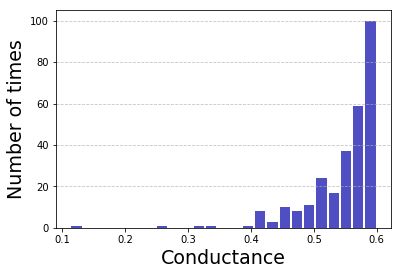

In [38]:
fig = plt.figure()
plt.hist(some_data, bins=25, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Number of times', fontsize=19)
plt.xlabel('Conductance', fontsize=19)
plt.grid(axis='y', alpha=0.75, linestyle='--')
plt.show()

fig.savefig('histogram_orkut.pdf')

## Collect data of ACL (without rounding)

In [ ]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.15/np.sum(g.d[rr])
            else:
                rho = 0.2/np.sum(g.d[rr])

            output_pr_clustering = approximate_PageRank(g,ref_node,method = "acl", rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            
            number_experiments += 1
            
            S = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_acl_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_acl_ = set(rr).intersection(S)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time ACL without rounding: ", end - start)
print("Number of experiments: ", number_experiments)

55
outer: 0 number of node:  773355  completed:  0.0  degree:  5.0
conductance:  0.07705934455270151 f1score:  0.9487895716945997 precision:  0.9025686448184234 recall:  1.0
outer: 0 number of node:  772094  completed:  0.01818181818181818  degree:  10.0
conductance:  0.12111292962356793 f1score:  0.9094154395359214 precision:  0.8338788870703764 recall:  1.0
outer: 0 number of node:  26663  completed:  0.03636363636363636  degree:  30.0
conductance:  0.09356223175965665 f1score:  0.9331501831501832 precision:  0.8746781115879828 recall:  1.0
outer: 0 number of node:  771870  completed:  0.05454545454545454  degree:  14.0
conductance:  0.11352253756260434 f1score:  0.9192602616147948 precision:  0.8505843071786311 recall:  1.0
outer: 0 number of node:  771627  completed:  0.07272727272727272  degree:  10.0
conductance:  0.07705934455270151 f1score:  0.9487895716945997 precision:  0.9025686448184234 recall:  1.0
outer: 0 number of node:  771624  completed:  0.09090909090909091  degree: 

outer: 0 number of node:  771876  completed:  0.8181818181818182  degree:  6.0
conductance:  0.09169550173010381 f1score:  0.9370114942528736 precision:  0.8814878892733564 recall:  1.0
outer: 0 number of node:  771623  completed:  0.8363636363636363  degree:  23.0
conductance:  0.09169550173010381 f1score:  0.9370114942528736 precision:  0.8814878892733564 recall:  1.0
outer: 0 number of node:  772162  completed:  0.8545454545454545  degree:  9.0
conductance:  0.07705934455270151 f1score:  0.9487895716945997 precision:  0.9025686448184234 recall:  1.0
outer: 0 number of node:  771620  completed:  0.8727272727272727  degree:  25.0
conductance:  0.09356223175965665 f1score:  0.9331501831501832 precision:  0.8746781115879828 recall:  1.0
outer: 0 number of node:  26674  completed:  0.8909090909090909  degree:  18.0
conductance:  0.09897610921501707 f1score:  0.9301688726608854 precision:  0.8694539249146758 recall:  1.0
outer: 0 number of node:  772090  completed:  0.9090909090909091  de

outer: 1 number of node:  100276  completed:  0.07710843373493977  degree:  270.0
conductance:  0.7212355999592212 f1score:  0.4713739966519294 precision:  0.5597716382913651 recall:  0.40708778173190985
outer: 1 number of node:  5195  completed:  0.07951807228915662  degree:  242.0
conductance:  0.693713282978561 f1score:  0.5234925084259351 precision:  0.5984397650110628 recall:  0.4652283511269276
outer: 1 number of node:  48559  completed:  0.0819277108433735  degree:  48.0
conductance:  0.8480340063761955 f1score:  0.009718461367261396 precision:  0.012971581344687592 recall:  0.007769869513641755
outer: 1 number of node:  30453  completed:  0.08433734939759036  degree:  241.0
conductance:  0.8208745669059535 f1score:  0.062419914156936894 precision:  0.078874068706266 recall:  0.05164590747330961
outer: 1 number of node:  128563  completed:  0.08674698795180723  degree:  54.0
conductance:  0.688082812901018 f1score:  0.4265648534099268 precision:  0.5209171015484644 recall:  0.36

outer: 1 number of node:  255848  completed:  0.17590361445783131  degree:  91.0
conductance:  0.6122279546937082 f1score:  0.5129391297471483 precision:  0.7693174405503173 recall:  0.38472716488730724
outer: 1 number of node:  257828  completed:  0.1783132530120482  degree:  102.0
conductance:  0.7421919008574827 f1score:  0.3270619956939051 precision:  0.5086687112724542 recall:  0.24101423487544485
outer: 1 number of node:  125178  completed:  0.18072289156626506  degree:  167.0
conductance:  0.7805999679161543 f1score:  0.199385742355163 precision:  0.2794502967755735 recall:  0.15498220640569396
outer: 1 number of node:  31187  completed:  0.18313253012048192  degree:  271.0
conductance:  0.7799180422753687 f1score:  0.31840445198300016 precision:  0.44549624020052264 recall:  0.24773131672597865
outer: 1 number of node:  67872  completed:  0.1855421686746988  degree:  76.0
conductance:  0.7933948693358907 f1score:  0.22057773192603763 precision:  0.3331934787820667 recall:  0.16

outer: 1 number of node:  273831  completed:  0.2746987951807229  degree:  71.0
conductance:  0.759709128350333 f1score:  0.23165074757153442 precision:  0.3671611055696773 recall:  0.16920225385527876
outer: 1 number of node:  15892  completed:  0.27710843373493976  degree:  190.0
conductance:  0.6986871027149052 f1score:  0.5256276549741816 precision:  0.6137943325610408 recall:  0.45960854092526693
outer: 1 number of node:  255855  completed:  0.27951807228915665  degree:  179.0
conductance:  0.5916363296928965 f1score:  0.6426676583612247 precision:  0.7259031083730048 recall:  0.5765569395017793
outer: 1 number of node:  68821  completed:  0.2819277108433735  degree:  295.0
conductance:  0.7221581124505122 f1score:  0.40579475950778476 precision:  0.4458252702966606 recall:  0.3723606168446026
outer: 1 number of node:  102257  completed:  0.28433734939759037  degree:  145.0
conductance:  0.7836902800658978 f1score:  0.14284613903331408 precision:  0.20367929708951127 recall:  0.10

outer: 1 number of node:  255112  completed:  0.37349397590361444  degree:  52.0
conductance:  0.7444588464031108 f1score:  0.45900305188199386 precision:  0.7310434219053791 recall:  0.33451957295373663
outer: 1 number of node:  5099  completed:  0.3759036144578313  degree:  174.0
conductance:  0.6977586104571801 f1score:  0.3708989821085017 precision:  0.43286711903301744 recall:  0.3244513641755635
outer: 1 number of node:  41359  completed:  0.3783132530120482  degree:  202.0
conductance:  0.8131086721286134 f1score:  0.16944303273288536 precision:  0.2319266244138713 recall:  0.13348161328588376
outer: 1 number of node:  87774  completed:  0.38072289156626504  degree:  260.0
conductance:  0.81198092894494 f1score:  0.05134945084382534 precision:  0.05896262688403568 recall:  0.04547746144721234
outer: 1 number of node:  242380  completed:  0.38313253012048193  degree:  156.0
conductance:  0.7468572221451367 f1score:  0.2819424981879681 precision:  0.4048008880255307 recall:  0.216

outer: 1 number of node:  5237  completed:  0.472289156626506  degree:  183.0
conductance:  0.6797602762035047 f1score:  0.5056699532129735 precision:  0.6230864438798775 recall:  0.42548932384341637
outer: 1 number of node:  5373  completed:  0.4746987951807229  degree:  219.0
conductance:  0.7103713892709766 f1score:  0.4923543639568729 precision:  0.5506648326455754 recall:  0.44521055753262156
outer: 1 number of node:  25859  completed:  0.4771084337349398  degree:  201.0
conductance:  0.5781998170764513 f1score:  0.6926080145453365 precision:  0.7651405103925683 recall:  0.6326364175563464
outer: 1 number of node:  125128  completed:  0.4795180722891566  degree:  271.0
conductance:  0.5577740675077887 f1score:  0.712586727419008 precision:  0.7698848477546173 recall:  0.663226571767497
outer: 1 number of node:  288719  completed:  0.4819277108433735  degree:  15.0
conductance:  0.7458912768647282 f1score:  0.005937443268583877 precision:  0.010609472197839942 recall:  0.0041221826

outer: 1 number of node:  48978  completed:  0.5710843373493976  degree:  138.0
conductance:  0.6630745443470927 f1score:  0.41089297713528145 precision:  0.5300332661762639 recall:  0.33548339264531435
outer: 1 number of node:  260527  completed:  0.5734939759036145  degree:  42.0
conductance:  0.7911578471279964 f1score:  0.014034889947298707 precision:  0.1412365286443562 recall:  0.007384341637010676
outer: 1 number of node:  5379  completed:  0.5759036144578313  degree:  177.0
conductance:  0.586073336312754 f1score:  0.6385444249272474 precision:  0.7775011172827683 recall:  0.5417259786476868
outer: 1 number of node:  25857  completed:  0.5783132530120482  degree:  82.0
conductance:  0.6069263719388992 f1score:  0.6305887182293984 precision:  0.7449284732886123 recall:  0.5466785290628707
outer: 1 number of node:  67113  completed:  0.5807228915662651  degree:  49.0
conductance:  0.8624787268981579 f1score:  0.03856023302586864 precision:  0.05810169289105186 recall:  0.02885527

outer: 1 number of node:  125188  completed:  0.6698795180722892  degree:  155.0
conductance:  0.6842767861157322 f1score:  0.48040599703364845 precision:  0.6043792994919294 recall:  0.39863582443653617
outer: 1 number of node:  5190  completed:  0.672289156626506  degree:  315.0
conductance:  0.5889354670909703 f1score:  0.5823119866529775 precision:  0.6342430807939614 recall:  0.5382413997627521
outer: 1 number of node:  5235  completed:  0.6746987951807228  degree:  214.0
conductance:  0.5799454101422209 f1score:  0.6292148372601514 precision:  0.7500359143801179 recall:  0.5419187425860024
outer: 1 number of node:  260433  completed:  0.6771084337349398  degree:  70.0
conductance:  0.7829603455045151 f1score:  0.23702020919115907 precision:  0.327705797670462 recall:  0.18564650059311982
outer: 1 number of node:  125138  completed:  0.6795180722891566  degree:  163.0
conductance:  0.5356821926014678 f1score:  0.7326735950221751 precision:  0.8288527781937997 recall:  0.6564946619

outer: 1 number of node:  5339  completed:  0.7686746987951807  degree:  87.0
conductance:  0.5346895129465081 f1score:  0.6807537693151043 precision:  0.9248160501056598 recall:  0.5386120996441282
outer: 1 number of node:  257838  completed:  0.7710843373493976  degree:  74.0
conductance:  0.6498616661543191 f1score:  0.48584730311022994 precision:  0.6026524965965483 recall:  0.4069691577698695
outer: 1 number of node:  84811  completed:  0.7734939759036145  degree:  522.0
conductance:  0.929097550751542 f1score:  0.023938519752015074 precision:  0.02531792098691935 recall:  0.022701660735468563
outer: 1 number of node:  175175  completed:  0.7759036144578313  degree:  79.0
conductance:  0.8440279107949104 f1score:  0.08008291857747704 precision:  0.11757443509718912 recall:  0.06072064056939502
outer: 1 number of node:  192666  completed:  0.7783132530120482  degree:  49.0
conductance:  0.6334157419651584 f1score:  0.500714104043981 precision:  0.7357270166158799 recall:  0.3794928

outer: 1 number of node:  23193  completed:  0.8674698795180723  degree:  183.0
conductance:  0.6007263033861964 f1score:  0.5596221761779732 precision:  0.6443238231373988 recall:  0.4946026097271649
outer: 1 number of node:  262014  completed:  0.8698795180722891  degree:  59.0
conductance:  0.8326503241189182 f1score:  0.018464050325942113 precision:  0.04849593239578735 recall:  0.011402728351126927
outer: 1 number of node:  32003  completed:  0.8722891566265061  degree:  187.0
conductance:  0.6643815635939323 f1score:  0.5273125735967552 precision:  0.5878427654609102 recall:  0.47808422301304865
outer: 1 number of node:  5199  completed:  0.8746987951807229  degree:  338.0
conductance:  0.7771781750515053 f1score:  0.3942284106485824 precision:  0.3838977097091471 recall:  0.4051304863582444
outer: 1 number of node:  255836  completed:  0.8771084337349397  degree:  127.0
conductance:  0.6608756440462936 f1score:  0.46006618707749164 precision:  0.6316961396059343 recall:  0.36177

outer: 1 number of node:  111939  completed:  0.9662650602409638  degree:  240.0
conductance:  0.7525485567120935 f1score:  0.15743676495912642 precision:  0.24844144633779852 recall:  0.11522835112692764
outer: 1 number of node:  260721  completed:  0.9686746987951808  degree:  89.0
conductance:  0.7620150550086856 f1score:  0.09741470900720105 precision:  0.2389114070642733 recall:  0.06118030842230131
outer: 1 number of node:  114299  completed:  0.9710843373493976  degree:  113.0
conductance:  0.6556232291457511 f1score:  0.4273714402786314 precision:  0.5351939852307966 recall:  0.35570877817319096
outer: 1 number of node:  5262  completed:  0.9734939759036144  degree:  316.0
conductance:  0.6664190193164933 f1score:  0.5645505426883947 precision:  0.5897344789715098 recall:  0.541429418742586
outer: 1 number of node:  30315  completed:  0.9759036144578314  degree:  174.0
conductance:  0.8183887825322088 f1score:  0.32079099666333627 precision:  0.4402390438247012 recall:  0.25232

outer: 2 number of node:  206317  completed:  0.005613126079447323  degree:  99.0
conductance:  0.743954637087143 f1score:  0.110424906230642 precision:  0.15498437903064002 recall:  0.08576628828533513
outer: 2 number of node:  555786  completed:  0.005829015544041451  degree:  114.0
conductance:  0.7847005504414509 f1score:  0.06826445497463916 precision:  0.10162518753169089 recall:  0.051393419654328296
outer: 2 number of node:  537824  completed:  0.006044905008635579  degree:  48.0
conductance:  0.7400964553001733 f1score:  0.03386188124484586 precision:  0.058502800838628854 recall:  0.02382639223005303
outer: 2 number of node:  209822  completed:  0.006260794473229706  degree:  96.0
conductance:  0.6202776855630846 f1score:  0.35445191172320717 precision:  0.4390575875334414 recall:  0.2971848746160231
outer: 2 number of node:  186980  completed:  0.006476683937823834  degree:  181.0
conductance:  0.5223928701835695 f1score:  0.45161812959634384 precision:  0.5742978195637496 r

outer: 2 number of node:  208347  completed:  0.014248704663212436  degree:  616.0
conductance:  0.7165204380058492 f1score:  0.16161995354633937 precision:  0.24713595864789498 recall:  0.12007174617609272
outer: 2 number of node:  58537  completed:  0.014464594127806563  degree:  245.0
conductance:  0.6341704338125065 f1score:  0.2299551002861987 precision:  0.35815825890049063 recall:  0.16933974484373926
outer: 2 number of node:  382899  completed:  0.01468048359240069  degree:  66.0
conductance:  0.771441185560183 f1score:  0.11724592747860779 precision:  0.18916277906138246 recall:  0.08494942872702087
outer: 2 number of node:  185090  completed:  0.014896373056994818  degree:  163.0
conductance:  0.829515158095376 f1score:  0.07676302787907306 precision:  0.12595755974569625 recall:  0.055202787368020347
outer: 2 number of node:  75868  completed:  0.015112262521588947  degree:  213.0
conductance:  0.7293800967977193 f1score:  0.0032585559145789063 precision:  0.0048982297951335

outer: 2 number of node:  10466  completed:  0.022884283246977548  degree:  411.0
conductance:  0.6633989810660786 f1score:  0.24982240440934605 precision:  0.41234887080830357 recall:  0.17919360893311267
outer: 2 number of node:  192137  completed:  0.023100172711571675  degree:  158.0
conductance:  0.5979806519994364 f1score:  0.28315218787738633 precision:  0.40217608159332774 recall:  0.2184901051607548
outer: 2 number of node:  2218506  completed:  0.023316062176165803  degree:  36.0
conductance:  0.7129303599374022 f1score:  0.04816494532563088 precision:  0.09833480046948356 recall:  0.03189321081321145
outer: 2 number of node:  16844  completed:  0.02353195164075993  degree:  388.0
conductance:  0.5514526307563058 f1score:  0.4406594462879241 precision:  0.5821941747151289 recall:  0.3544826820486521
outer: 2 number of node:  247579  completed:  0.023747841105354058  degree:  130.0
conductance:  0.7748638886105425 f1score:  0.1012913180085362 precision:  0.1420616402078532 rec

outer: 2 number of node:  245027  completed:  0.03151986183074266  degree:  133.0
conductance:  0.7481725921560924 f1score:  0.14663983323685129 precision:  0.21859752504419563 recall:  0.11032362442436515
outer: 2 number of node:  846013  completed:  0.03173575129533679  degree:  19.0
conductance:  0.7300908435978984 f1score:  0.13045102779626763 precision:  0.23864279313313772 recall:  0.08975806153146627
outer: 2 number of node:  496381  completed:  0.03195164075993091  degree:  51.0
conductance:  0.7429217689727791 f1score:  0.006876360400470845 precision:  0.012933914014843154 recall:  0.004683063778490951
outer: 2 number of node:  207977  completed:  0.032167530224525044  degree:  161.0
conductance:  0.48494352476673275 f1score:  0.46736480063739244 precision:  0.5795847852415043 recall:  0.3915519802896283
outer: 2 number of node:  729023  completed:  0.03238341968911917  degree:  37.0
conductance:  0.8919260241087225 f1score:  0.025913927066318933 precision:  0.0408391974378082

outer: 2 number of node:  420886  completed:  0.04015544041450777  degree:  106.0
conductance:  0.571336327905671 f1score:  0.12711935131742785 precision:  0.40189408064618265 recall:  0.07550002907914286
outer: 2 number of node:  67623  completed:  0.0403713298791019  degree:  145.0
conductance:  0.6631028663511439 f1score:  0.2720902198918661 precision:  0.3972415018208118 recall:  0.20690471029243043
outer: 2 number of node:  191596  completed:  0.04058721934369603  degree:  185.0
conductance:  0.519536935739289 f1score:  0.4808022820273262 precision:  0.5828730998303429 recall:  0.4091527923907814
outer: 2 number of node:  22932  completed:  0.040803108808290155  degree:  225.0
conductance:  0.4742675154138843 f1score:  0.48922104693456864 precision:  0.6148269363879698 recall:  0.40623033853409396
outer: 2 number of node:  44812  completed:  0.041018998272884286  degree:  241.0
conductance:  0.8543961217658601 f1score:  0.037416488453440755 precision:  0.061700007897406615 recall:

outer: 2 number of node:  444351  completed:  0.04900690846286701  degree:  40.0
conductance:  0.7440071158550144 f1score:  0.11421855460281857 precision:  0.17720702690682677 recall:  0.08426606886998451
outer: 2 number of node:  187948  completed:  0.04922279792746114  degree:  136.0
conductance:  0.5792246831434869 f1score:  0.4354370415647922 precision:  0.5654294978425892 recall:  0.35404252956820115
outer: 2 number of node:  3967  completed:  0.049438687392055265  degree:  274.0
conductance:  0.45511175584988695 f1score:  0.49165842505875895 precision:  0.6236994325350628 recall:  0.40575714157312875
outer: 2 number of node:  57853  completed:  0.049654576856649396  degree:  86.0
conductance:  0.7389325510687058 f1score:  0.12902991827603927 precision:  0.19503579288527825 recall:  0.09640396745250847
outer: 2 number of node:  183639  completed:  0.04987046632124352  degree:  282.0
conductance:  0.4930644604587434 f1score:  0.46807997077598357 precision:  0.6044326370948342 recal

outer: 2 number of node:  188073  completed:  0.05785837651122625  degree:  302.0
conductance:  0.7000919426934705 f1score:  0.23288196725648497 precision:  0.3498591713499148 recall:  0.17452772828448918
outer: 2 number of node:  108650  completed:  0.05807426597582038  degree:  260.0
conductance:  0.4381827969065258 f1score:  0.523421089428263 precision:  0.6451005146754137 recall:  0.4403599997885153
outer: 2 number of node:  108501  completed:  0.05829015544041451  degree:  112.0
conductance:  0.5780153050159557 f1score:  0.3791680737899479 precision:  0.48583408206049716 recall:  0.3109075864840144
outer: 2 number of node:  127253  completed:  0.05850604490500864  degree:  354.0
conductance:  0.5633458802505104 f1score:  0.3557508141262066 precision:  0.5378908872997911 recall:  0.2657595736468946
outer: 2 number of node:  583672  completed:  0.05872193436960276  degree:  109.0
conductance:  0.5873580428425484 f1score:  0.34612243284899424 precision:  0.458923191127025 recall:  0.

outer: 2 number of node:  273438  completed:  0.0667098445595855  degree:  97.0
conductance:  0.8195874633383999 f1score:  0.028370865052148034 precision:  0.042904776176917646 recall:  0.021192086243450585
outer: 2 number of node:  961286  completed:  0.06692573402417962  degree:  108.0
conductance:  0.7281081560628977 f1score:  0.1207775807559348 precision:  0.15924803147050615 recall:  0.09727766351730738
outer: 2 number of node:  713270  completed:  0.06714162348877374  degree:  175.0
conductance:  0.5576834022974769 f1score:  0.1408951731576013 precision:  0.22835032915202616 recall:  0.10187745520490221
outer: 2 number of node:  188405  completed:  0.06735751295336788  degree:  239.0
conductance:  0.6721028969671271 f1score:  0.30480462587308726 precision:  0.46580339329495357 recall:  0.2265133050296343
outer: 2 number of node:  121873  completed:  0.067573402417962  degree:  105.0
conductance:  0.5343059682391302 f1score:  0.43316462813399004 precision:  0.5812795601998687 reca

outer: 2 number of node:  34912  completed:  0.0753454231433506  degree:  149.0
conductance:  0.7445286233021025 f1score:  0.004013404124682781 precision:  0.015618415743936881 recall:  0.002302539402238565
outer: 2 number of node:  209477  completed:  0.07556131260794473  degree:  363.0
conductance:  0.43470252933424364 f1score:  0.49728182392312315 precision:  0.6219891713373875 recall:  0.41422974637700316
outer: 2 number of node:  67182  completed:  0.07577720207253887  degree:  175.0
conductance:  0.6201093846209569 f1score:  0.10817776857708489 precision:  0.18365750869938288 recall:  0.0766684819101296
outer: 2 number of node:  273455  completed:  0.07599309153713299  degree:  97.0
conductance:  0.707049458963701 f1score:  0.13438538615868484 precision:  0.23827954094167536 recall:  0.09358196881658463
outer: 2 number of node:  819308  completed:  0.07620898100172711  degree:  32.0
conductance:  0.7528248729519043 f1score:  0.16254164435366542 precision:  0.2872476206747535 reca

outer: 2 number of node:  63272  completed:  0.08419689119170984  degree:  137.0
conductance:  0.6762338473764976 f1score:  0.2242390562902134 precision:  0.3338701202280647 recall:  0.16880838959706881
outer: 2 number of node:  208355  completed:  0.08441278065630398  degree:  177.0
conductance:  0.5335287858058071 f1score:  0.44055755587801737 precision:  0.5821986231459161 recall:  0.35434918234737417
outer: 2 number of node:  178317  completed:  0.0846286701208981  degree:  367.0
conductance:  0.5668778101063456 f1score:  0.3897082013198076 precision:  0.5513987950554221 recall:  0.3013431920439465
outer: 2 number of node:  167630  completed:  0.08484455958549222  degree:  120.0
conductance:  0.6309573190699705 f1score:  0.04679410630835629 precision:  0.08106426370074996 recall:  0.03288983234552366
outer: 2 number of node:  58547  completed:  0.08506044905008636  degree:  328.0
conductance:  0.6834302976057284 f1score:  0.1660802315102381 precision:  0.2587631461176997 recall:  0

outer: 2 number of node:  22806  completed:  0.09304835924006909  degree:  116.0
conductance:  0.6284576448146891 f1score:  0.3840650943785882 precision:  0.5120442120380445 recall:  0.30726740651055573
outer: 2 number of node:  375906  completed:  0.09326424870466321  degree:  131.0
conductance:  0.6791628922490883 f1score:  0.11231846497469584 precision:  0.15962527061218626 recall:  0.0866413061293546
outer: 2 number of node:  59903  completed:  0.09348013816925733  degree:  248.0
conductance:  0.7329526021491692 f1score:  0.1283235459442359 precision:  0.22304230423042304 recall:  0.09007264498596271
outer: 2 number of node:  208326  completed:  0.09369602763385147  degree:  217.0
conductance:  0.5665848143735869 f1score:  0.3549020178684883 precision:  0.503851109868469 recall:  0.27392420389237543
outer: 2 number of node:  2550886  completed:  0.0939119170984456  degree:  24.0
conductance:  0.7864717367017764 f1score:  0.05134244857604476 precision:  0.0949926651413968 recall:  0

outer: 2 number of node:  110887  completed:  0.10189982728842832  degree:  164.0
conductance:  0.6593711994049714 f1score:  0.29635519523265075 precision:  0.4298730538440663 recall:  0.2261220583803446
outer: 2 number of node:  207943  completed:  0.10211571675302246  degree:  80.0
conductance:  0.6536902091373953 f1score:  0.3221653698679859 precision:  0.4571829815563066 recall:  0.24871390881838223
outer: 2 number of node:  206382  completed:  0.10233160621761658  degree:  31.0
conductance:  0.7574443148934628 f1score:  0.12312456441347758 precision:  0.20224854859269373 recall:  0.08850104949270114
outer: 2 number of node:  291338  completed:  0.10254749568221071  degree:  51.0
conductance:  0.793628332122232 f1score:  0.09511833767009872 precision:  0.17266016960054517 recall:  0.06563955609366656
outer: 2 number of node:  33532  completed:  0.10276338514680483  degree:  104.0
conductance:  0.6761895012394066 f1score:  0.3002640480685754 precision:  0.42697738357256193 recall:  

outer: 2 number of node:  375496  completed:  0.11075129533678757  degree:  109.0
conductance:  0.7019974933971549 f1score:  0.007463370819323935 precision:  0.011428664901839436 recall:  0.005540898492642977
outer: 2 number of node:  214828  completed:  0.1109671848013817  degree:  64.0
conductance:  0.7400564810601195 f1score:  0.20822569037484837 precision:  0.27561842841559087 recall:  0.16731477907782108
outer: 2 number of node:  38962  completed:  0.11118307426597582  degree:  106.0
conductance:  0.6729906466000404 f1score:  0.20116625508687133 precision:  0.3003483570515395 recall:  0.1512274041842243
outer: 2 number of node:  208979  completed:  0.11139896373056994  degree:  89.0
conductance:  0.6315804129298139 f1score:  0.34495081391024307 precision:  0.4519758642330982 recall:  0.2789073115539365
outer: 2 number of node:  211988  completed:  0.11161485319516408  degree:  104.0
conductance:  0.6315879806766521 f1score:  0.38846814440339617 precision:  0.5018105173265461 recal

outer: 2 number of node:  212045  completed:  0.1196027633851468  degree:  183.0
conductance:  0.7054477496969007 f1score:  0.15574821460563248 precision:  0.2320531340283884 recall:  0.11720745060511052
outer: 2 number of node:  188009  completed:  0.11981865284974093  degree:  88.0
conductance:  0.58621741395869 f1score:  0.42407984904009355 precision:  0.5032833403835435 recall:  0.36641570485198716
outer: 2 number of node:  642001  completed:  0.12003454231433507  degree:  71.0
conductance:  0.7325654034551006 f1score:  0.12163162960981583 precision:  0.19512736231850214 recall:  0.08835301021999693
outer: 2 number of node:  3827  completed:  0.12025043177892919  degree:  86.0
conductance:  0.7836392799857423 f1score:  0.014087332465544057 precision:  0.022051306603282066 recall:  0.010349531297088385
outer: 2 number of node:  67668  completed:  0.12046632124352331  degree:  84.0
conductance:  0.7198775096308934 f1score:  0.16257544574189214 precision:  0.23603300295154483 recall: 

outer: 2 number of node:  197595  completed:  0.12845423143350604  degree:  200.0
conductance:  0.6101122704460229 f1score:  0.26606648604526884 precision:  0.4037566136142948 recall:  0.19840566990414457
outer: 2 number of node:  64583  completed:  0.12867012089810018  degree:  280.0
conductance:  0.6280347483039281 f1score:  0.256459011184106 precision:  0.3698457844768328 recall:  0.19628289247590397
outer: 2 number of node:  305588  completed:  0.12888601036269431  degree:  161.0
conductance:  0.6577053707427407 f1score:  0.007876537705657322 precision:  0.011130610264493811 recall:  0.00609472398606316
outer: 2 number of node:  206954  completed:  0.12910189982728842  degree:  61.0
conductance:  0.5682718683328254 f1score:  0.4273142687749528 precision:  0.5294684234793957 recall:  0.3582034905545657
outer: 2 number of node:  167508  completed:  0.12931778929188256  degree:  151.0
conductance:  0.6665140939085327 f1score:  0.0458189697169343 precision:  0.1870785026900053 recall: 

outer: 2 number of node:  334224  completed:  0.13708981001727116  degree:  104.0
conductance:  0.5916350856127975 f1score:  0.14355389108740993 precision:  0.21697210175346657 recall:  0.10725974019107641
outer: 2 number of node:  207921  completed:  0.13730569948186527  degree:  70.0
conductance:  0.49485140170917663 f1score:  0.4763551059306503 precision:  0.534772790118905 recall:  0.42944342520580103
outer: 2 number of node:  108627  completed:  0.1375215889464594  degree:  226.0
conductance:  0.4890847431647922 f1score:  0.5087189065816912 precision:  0.623062479642864 recall:  0.4298359936343113
outer: 2 number of node:  116627  completed:  0.13773747841105355  degree:  269.0
conductance:  0.5978153421490333 f1score:  0.34552418162672466 precision:  0.48112488646149126 recall:  0.26955308000993977
outer: 2 number of node:  46960  completed:  0.13795336787564766  degree:  497.0
conductance:  0.5540030934287916 f1score:  0.24673761483298373 precision:  0.3647788819168913 recall:  

outer: 2 number of node:  22751  completed:  0.1459412780656304  degree:  286.0
conductance:  0.6521709527051799 f1score:  0.34968763615409476 precision:  0.5212512439113811 recall:  0.2630935449589984
outer: 2 number of node:  213329  completed:  0.14615716753022454  degree:  93.0
conductance:  0.6884769303201507 f1score:  0.23557263224771963 precision:  0.3234118651498719 recall:  0.1852566102178821
outer: 2 number of node:  61749  completed:  0.14637305699481865  degree:  95.0
conductance:  0.7041461331857626 f1score:  0.19895389482815806 precision:  0.2789945471979849 recall:  0.15460058475512717
outer: 2 number of node:  59899  completed:  0.14658894645941278  degree:  180.0
conductance:  0.6768338532321826 f1score:  0.22172124820723074 precision:  0.3189995111213685 recall:  0.16990810990858574
outer: 2 number of node:  207545  completed:  0.14680483592400692  degree:  173.0
conductance:  0.5077598086143212 f1score:  0.4952867655601545 precision:  0.6159391088456904 recall:  0.41

outer: 2 number of node:  416964  completed:  0.15479274611398963  degree:  66.0
conductance:  0.7717818138216554 f1score:  0.1450442138730785 precision:  0.25526663757872897 recall:  0.10130248124395286
outer: 2 number of node:  115052  completed:  0.15500863557858377  degree:  36.0
conductance:  0.7517664930083494 f1score:  0.11910285407091346 precision:  0.2228917191448325 recall:  0.08126298648084213
outer: 2 number of node:  167555  completed:  0.15522452504317788  degree:  214.0
conductance:  0.7138743793720814 f1score:  0.04868130934661934 precision:  0.08074416211315577 recall:  0.03484474381275147
outer: 2 number of node:  121849  completed:  0.15544041450777202  degree:  157.0
conductance:  0.6520948139027926 f1score:  0.3377232687833555 precision:  0.46231999577338934 recall:  0.26602789482867095
outer: 2 number of node:  220205  completed:  0.15565630397236616  degree:  175.0
conductance:  0.6039846743295019 f1score:  0.16193696632308383 precision:  0.25744724984730977 reca

outer: 2 number of node:  411433  completed:  0.16364421416234887  degree:  117.0
conductance:  0.6794451213796981 f1score:  0.02025323692678212 precision:  0.031239837958497534 recall:  0.014983689244418126
outer: 2 number of node:  47061  completed:  0.163860103626943  degree:  330.0
conductance:  0.5623042523022267 f1score:  0.30851826092440726 precision:  0.4573419345456056 recall:  0.23277192963904852
outer: 2 number of node:  67673  completed:  0.16407599309153714  degree:  428.0
conductance:  0.5143780776604142 f1score:  0.40485905985768955 precision:  0.5622321730631884 recall:  0.3163189506130412
outer: 2 number of node:  125585  completed:  0.16429188255613125  degree:  80.0
conductance:  0.4986096230934983 f1score:  0.46996689992366425 precision:  0.5916625537191077 recall:  0.3897926921470453
outer: 2 number of node:  827814  completed:  0.1645077720207254  degree:  97.0
conductance:  0.7518804460260513 f1score:  0.0066720428406380605 precision:  0.009450074006603667 recall

outer: 2 number of node:  116668  completed:  0.17249568221070813  degree:  282.0
conductance:  0.5973331053166882 f1score:  0.37949220961757524 precision:  0.5127651818582757 recall:  0.3012057270050069
outer: 2 number of node:  133272  completed:  0.17271157167530224  degree:  27.0
conductance:  0.8114766712252797 f1score:  0.09951324254581688 precision:  0.15905784792815394 recall:  0.0724070657030015
outer: 2 number of node:  2569824  completed:  0.17292746113989638  degree:  21.0
conductance:  0.7385154050059044 f1score:  0.10243204005006258 precision:  0.21120258965952915 recall:  0.06761165069076182
outer: 2 number of node:  183652  completed:  0.17314335060449051  degree:  313.0
conductance:  0.44262096749801894 f1score:  0.5016690685391958 precision:  0.6334831501454816 recall:  0.41526205594827087
outer: 2 number of node:  860361  completed:  0.17335924006908462  degree:  118.0
conductance:  0.7084288507218764 f1score:  0.023277048568973058 precision:  0.03598735713870922 rec

outer: 2 number of node:  92191  completed:  0.18134715025906736  degree:  301.0
conductance:  0.5787508400325402 f1score:  0.3719799301268512 precision:  0.5414862386248225 recall:  0.2832969403454602
outer: 2 number of node:  129305  completed:  0.18156303972366147  degree:  157.0
conductance:  0.8754899120064661 f1score:  0.07900491535538176 precision:  0.1534434904610129 recall:  0.05319764829041076
outer: 2 number of node:  554696  completed:  0.1817789291882556  degree:  32.0
conductance:  0.7841767695951651 f1score:  0.19098458395483317 precision:  0.27028105939820335 recall:  0.1476625656263383
outer: 2 number of node:  208375  completed:  0.18199481865284975  degree:  150.0
conductance:  0.5456577913327804 f1score:  0.41590599373806975 precision:  0.5504448551581211 recall:  0.3342171630388233
outer: 2 number of node:  190882  completed:  0.18221070811744386  degree:  93.0
conductance:  0.6969550312563016 f1score:  0.07211397392725902 precision:  0.10626486302850613 recall:  0

outer: 2 number of node:  672978  completed:  0.1901986183074266  degree:  179.0
conductance:  0.5870573172399219 f1score:  0.3107735214447143 precision:  0.4295181664066635 recall:  0.24346512353348596
outer: 2 number of node:  337713  completed:  0.19041450777202074  degree:  19.0
conductance:  0.7961115534996913 f1score:  0.014008917548388415 precision:  0.030711211717233174 recall:  0.009074014349235219
outer: 2 number of node:  22728  completed:  0.19063039723661485  degree:  305.0
conductance:  0.48400145839401487 f1score:  0.4631172410255012 precision:  0.5883906947943889 recall:  0.3818236852262093
outer: 2 number of node:  124431  completed:  0.19084628670120898  degree:  128.0
conductance:  0.7106025989506669 f1score:  0.2495147994504395 precision:  0.33784326828431327 recall:  0.19780029502112204
outer: 2 number of node:  213147  completed:  0.19106217616580312  degree:  243.0
conductance:  0.6105573796122576 f1score:  0.2927746805043314 precision:  0.41694271810506567 recal

outer: 2 number of node:  115113  completed:  0.19905008635578583  degree:  505.0
conductance:  0.4802813538622769 f1score:  0.4845479774181824 precision:  0.6295556781037983 recall:  0.3938346930035582
outer: 2 number of node:  876008  completed:  0.19926597582037997  degree:  31.0
conductance:  0.6572019556224145 f1score:  0.08346897570926046 precision:  0.19628103218732867 recall:  0.053004668524207064
outer: 2 number of node:  205751  completed:  0.19948186528497408  degree:  182.0
conductance:  0.5335851763104597 f1score:  0.42317960328315185 precision:  0.5377621836171661 recall:  0.34884925901056896
outer: 2 number of node:  125985  completed:  0.19969775474956822  degree:  183.0
conductance:  0.668917501992199 f1score:  0.13546274801804567 precision:  0.2187415274716207 recall:  0.09811038442626852
outer: 2 number of node:  555414  completed:  0.19991364421416236  degree:  113.0
conductance:  0.6213555133806316 f1score:  0.125534471727148 precision:  0.1996684636895667 recall: 

outer: 2 number of node:  660592  completed:  0.20790155440414507  degree:  83.0
conductance:  0.7118655616089654 f1score:  0.13381517167716236 precision:  0.20486537900735585 recall:  0.09935682223126907
outer: 2 number of node:  670165  completed:  0.2081174438687392  degree:  164.0
conductance:  0.6045606090764332 f1score:  0.12032171838957664 precision:  0.34327104896496813 recall:  0.0729450298457748
outer: 2 number of node:  844099  completed:  0.20833333333333334  degree:  71.0
conductance:  0.5211229766942038 f1score:  0.021158894257438644 precision:  0.04600845450722617 recall:  0.013738573218638144
outer: 2 number of node:  183724  completed:  0.20854922279792745  degree:  269.0
conductance:  0.5216537294444301 f1score:  0.4562673912331817 precision:  0.5990492645984303 recall:  0.3684486012932288
outer: 2 number of node:  205814  completed:  0.2087651122625216  degree:  43.0
conductance:  0.7021902873668274 f1score:  0.2516137647072743 precision:  0.3488664219994282 recall: 

outer: 2 number of node:  670151  completed:  0.21675302245250433  degree:  132.0
conductance:  0.5265522087800039 f1score:  0.12995990134724764 precision:  0.4225428943406382 recall:  0.07678876381920176
outer: 2 number of node:  2487699  completed:  0.21696891191709844  degree:  38.0
conductance:  0.7487721506697512 f1score:  0.07558974232621873 precision:  0.13352505750051055 recall:  0.0527165206541221
outer: 2 number of node:  194293  completed:  0.21718480138169258  degree:  70.0
conductance:  0.8008266369662252 f1score:  0.12553617360513605 precision:  0.19803680841791027 recall:  0.09189405675191262
outer: 2 number of node:  22929  completed:  0.21740069084628671  degree:  423.0
conductance:  0.4061226234410155 f1score:  0.544396499261685 precision:  0.6467605316143958 recall:  0.4700075077059729
outer: 2 number of node:  67119  completed:  0.21761658031088082  degree:  171.0
conductance:  0.645102723363593 f1score:  0.19837528781274488 precision:  0.2901010779442481 recall:  0

outer: 2 number of node:  759489  completed:  0.22560449050086356  degree:  48.0
conductance:  0.7678350603385783 f1score:  0.0926706085678034 precision:  0.1397621636603983 recall:  0.06931542410608071
outer: 2 number of node:  715716  completed:  0.22582037996545767  degree:  115.0
conductance:  0.7348988569936321 f1score:  0.09314481072112671 precision:  0.13504650368614532 recall:  0.07108793004086941
outer: 2 number of node:  108451  completed:  0.2260362694300518  degree:  411.0
conductance:  0.5408797338878136 f1score:  0.3760744356949118 precision:  0.5292169404293385 recall:  0.2916717334870122
outer: 2 number of node:  146861  completed:  0.22625215889464595  degree:  70.0
conductance:  0.6391581274054542 f1score:  0.008397317951349945 precision:  0.010357631045748467 recall:  0.00706094459630219
outer: 2 number of node:  207025  completed:  0.22646804835924006  degree:  150.0
conductance:  0.60254815779478 f1score:  0.33333798851703106 precision:  0.44035596071409194 recall:

outer: 2 number of node:  98776  completed:  0.2344559585492228  degree:  114.0
conductance:  0.7872997551045875 f1score:  0.0269187967157666 precision:  0.03993199082812086 recall:  0.0203025288280048
outer: 2 number of node:  47856  completed:  0.23467184801381694  degree:  461.0
conductance:  0.4047554999356733 f1score:  0.5246565350884793 precision:  0.6491970854142057 recall:  0.4402079951781494
outer: 2 number of node:  78515  completed:  0.23488773747841105  degree:  142.0
conductance:  0.676497675801504 f1score:  0.13923076574473967 precision:  0.2215060461601908 recall:  0.10152189659456802
outer: 2 number of node:  177659  completed:  0.23510362694300518  degree:  114.0
conductance:  0.6087907524721878 f1score:  0.32442234301703843 precision:  0.4584918688195303 recall:  0.25102041355828253
outer: 2 number of node:  653869  completed:  0.23531951640759932  degree:  28.0
conductance:  0.7564430411517993 f1score:  0.03257502678229508 precision:  0.06111113131981856 recall:  0.0

outer: 2 number of node:  319735  completed:  0.24330742659758203  degree:  166.0
conductance:  0.6356803797468354 f1score:  0.04722582151403724 precision:  0.20209003536675524 recall:  0.026736950073755282
outer: 2 number of node:  245649  completed:  0.24352331606217617  degree:  189.0
conductance:  0.7689709501151352 f1score:  0.10095853394477648 precision:  0.15109839443135892 recall:  0.0758040382998747
outer: 2 number of node:  2427485  completed:  0.24373920552677028  degree:  48.0
conductance:  0.7325976400199435 f1score:  0.0752180335651585 precision:  0.132185474488948 recall:  0.05256451604375618
outer: 2 number of node:  178091  completed:  0.24395509499136442  degree:  199.0
conductance:  0.596472271705166 f1score:  0.00668541098254077 precision:  0.011140747136183531 recall:  0.004775588323931077
outer: 2 number of node:  110870  completed:  0.24417098445595856  degree:  226.0
conductance:  0.6270686521892609 f1score:  0.3187505432439765 precision:  0.4746610535123616 rec

outer: 2 number of node:  213588  completed:  0.25215889464594127  degree:  137.0
conductance:  0.5782763224702409 f1score:  0.34015732910862845 precision:  0.48398208413431043 recall:  0.2622304231279641
outer: 2 number of node:  232602  completed:  0.25237478411053543  degree:  63.0
conductance:  0.6967354596622889 f1score:  0.04680047025592775 precision:  0.08598406380135606 recall:  0.032149635982002656
outer: 2 number of node:  209349  completed:  0.25259067357512954  degree:  108.0
conductance:  0.6321445216854736 f1score:  0.23653668609988865 precision:  0.33650241583598167 recall:  0.1823619137248267
outer: 2 number of node:  583958  completed:  0.25280656303972365  degree:  189.0
conductance:  0.7418947520945565 f1score:  0.10570289247738912 precision:  0.1563116141151631 recall:  0.07985000449404935
outer: 2 number of node:  208763  completed:  0.25302245250431776  degree:  388.0
conductance:  0.5002571884735029 f1score:  0.4385278229127528 precision:  0.5886476339773807 reca

outer: 2 number of node:  22869  completed:  0.2610103626943005  degree:  594.0
conductance:  0.40779757020724705 f1score:  0.5415646951746027 precision:  0.658093448331928 recall:  0.4600954853308942
outer: 2 number of node:  214481  completed:  0.26122625215889467  degree:  105.0
conductance:  0.7699359604602344 f1score:  0.02830999765201441 precision:  0.04261153774612707 recall:  0.021196051581112305
outer: 2 number of node:  58578  completed:  0.2614421416234888  degree:  85.0
conductance:  0.6855807529230374 f1score:  0.21231882775585326 precision:  0.3211459805559125 recall:  0.15858046198827316
outer: 2 number of node:  183612  completed:  0.2616580310880829  degree:  276.0
conductance:  0.5439677145284622 f1score:  0.45102118183758577 precision:  0.5673842997066414 recall:  0.374264429863751
outer: 2 number of node:  124462  completed:  0.26187392055267705  degree:  6.0
conductance:  0.7238092684178871 f1score:  0.11278379469984562 precision:  0.2198309051973475 recall:  0.075

outer: 2 number of node:  1929461  completed:  0.26986183074265974  degree:  8.0
conductance:  0.7935482008017826 f1score:  0.02015465451607986 precision:  0.04676904714924418 recall:  0.012845050465530642
outer: 2 number of node:  125885  completed:  0.2700777202072539  degree:  98.0
conductance:  0.7137618590768575 f1score:  0.1311688603286227 precision:  0.20461837205327296 recall:  0.0965216058031395
outer: 2 number of node:  125970  completed:  0.270293609671848  degree:  112.0
conductance:  0.7096128258836238 f1score:  0.15073121029464914 precision:  0.22738967794572082 recall:  0.11272794082658785
outer: 2 number of node:  39002  completed:  0.2705094991364421  degree:  63.0
conductance:  0.754325918539971 f1score:  0.08806652358587988 precision:  0.1373398611896906 recall:  0.06481344408080829
outer: 2 number of node:  183611  completed:  0.2707253886010363  degree:  363.0
conductance:  0.5458391777758902 f1score:  0.42142506637140303 precision:  0.5766817646505157 recall:  0.3

outer: 2 number of node:  67710  completed:  0.27871329879101897  degree:  416.0
conductance:  0.5853420474041428 f1score:  0.31575444902146654 precision:  0.4583490558918087 recall:  0.2408308175468835
outer: 2 number of node:  211743  completed:  0.27892918825561314  degree:  63.0
conductance:  0.6102258903994972 f1score:  0.41389192641986744 precision:  0.5428449446591048 recall:  0.3344445090647619
outer: 2 number of node:  658558  completed:  0.27914507772020725  degree:  201.0
conductance:  0.6893512851897184 f1score:  0.13456083746644015 precision:  0.21223011339366568 recall:  0.09850956175088163
outer: 2 number of node:  120315  completed:  0.27936096718480136  degree:  246.0
conductance:  0.5241977279436687 f1score:  0.38230886657423363 precision:  0.50740331733345 recall:  0.3066963978872681
outer: 2 number of node:  280565  completed:  0.2795768566493955  degree:  105.0
conductance:  0.7747802410719749 f1score:  0.002741982096162618 precision:  0.004015316840366299 recall: 

outer: 2 number of node:  124857  completed:  0.28756476683937826  degree:  70.0
conductance:  0.6955641224482965 f1score:  0.06892655164558824 precision:  0.107195260065944 recall:  0.050793331888188055
outer: 2 number of node:  188158  completed:  0.28778065630397237  degree:  254.0
conductance:  0.4410595543453155 f1score:  0.4911872601234119 precision:  0.6220485203599924 recall:  0.40581529985883397
outer: 2 number of node:  167614  completed:  0.2879965457685665  degree:  198.0
conductance:  0.6883566978193146 f1score:  0.05277668148097306 precision:  0.09465855076428548 recall:  0.03658817060468756
outer: 2 number of node:  183600  completed:  0.28821243523316065  degree:  199.0
conductance:  0.5813134573625213 f1score:  0.4051141154016258 precision:  0.5623099947179999 recall:  0.3166057767039056
outer: 2 number of node:  559052  completed:  0.28842832469775476  degree:  53.0
conductance:  0.7101471727343145 f1score:  0.0821076013237342 precision:  0.14199268132568102 recall:  

outer: 2 number of node:  818664  completed:  0.2964162348877375  degree:  66.0
conductance:  0.718440909623917 f1score:  0.1101350803956708 precision:  0.16867965999547316 recall:  0.08175865368855709
outer: 2 number of node:  7884  completed:  0.2966321243523316  degree:  290.0
conductance:  0.5985367977665442 f1score:  0.40348727893594144 precision:  0.5571368364189266 recall:  0.31626607944421825
outer: 2 number of node:  215831  completed:  0.2968480138169257  degree:  97.0
conductance:  0.5526359926203388 f1score:  0.15996622590637907 precision:  0.24849620710013032 recall:  0.11794632518941096
outer: 2 number of node:  81791  completed:  0.2970639032815199  degree:  80.0
conductance:  0.6663050553265351 f1score:  0.09773713841028196 precision:  0.16714921443356356 recall:  0.0690589989372895
outer: 2 number of node:  237966  completed:  0.297279792746114  degree:  136.0
conductance:  0.546045174310912 f1score:  0.1345632865187275 precision:  0.21792348691784327 recall:  0.097331

outer: 2 number of node:  27856  completed:  0.30526770293609673  degree:  551.0
conductance:  0.8539803357296831 f1score:  0.005646892100496844 precision:  0.031972816964834 recall:  0.003096928713803076
outer: 2 number of node:  22941  completed:  0.30548359240069084  degree:  109.0
conductance:  0.5855674007944593 f1score:  0.37175245698413983 precision:  0.5229959318116982 recall:  0.28836199831869685
outer: 2 number of node:  186220  completed:  0.30569948186528495  degree:  413.0
conductance:  0.7948289531447592 f1score:  0.21715888392663737 precision:  0.3777019899226178 recall:  0.15238660456066702
outer: 2 number of node:  212725  completed:  0.3059153713298791  degree:  72.0
conductance:  0.6934108409781303 f1score:  0.22063935939158857 precision:  0.3208998153138151 recall:  0.16811445550626788
outer: 2 number of node:  124442  completed:  0.3061312607944732  degree:  49.0
conductance:  0.7641020945404601 f1score:  0.20221282614634079 precision:  0.2762069360192286 recall:  

outer: 2 number of node:  4561  completed:  0.31411917098445596  degree:  403.0
conductance:  0.5474696954636058 f1score:  0.21086155937346884 precision:  0.31408160382540823 recall:  0.15870470923500707
outer: 2 number of node:  100277  completed:  0.3143350604490501  degree:  293.0
conductance:  0.768740735568118 f1score:  0.18738994312269913 precision:  0.31869328263222546 recall:  0.1327119208624345
outer: 2 number of node:  125893  completed:  0.31455094991364424  degree:  178.0
conductance:  0.6995801185759558 f1score:  0.11112673460850184 precision:  0.1637820735603422 recall:  0.08409159401286884
outer: 2 number of node:  108781  completed:  0.31476683937823835  degree:  226.0
conductance:  0.6055270419613135 f1score:  0.12195993626441642 precision:  0.22165492405905318 recall:  0.0841233167141626
outer: 2 number of node:  22714  completed:  0.31498272884283246  degree:  247.0
conductance:  0.44628987978381424 f1score:  0.5167780259438725 precision:  0.6406361211704067 recall: 

outer: 2 number of node:  199906  completed:  0.3229706390328152  degree:  107.0
conductance:  0.6213362525602091 f1score:  0.010289940698921203 precision:  0.015231175453916496 recall:  0.007769418258529441
outer: 2 number of node:  500352  completed:  0.3231865284974093  degree:  152.0
conductance:  0.6274163644287519 f1score:  0.15156597841315053 precision:  0.25385516086852544 recall:  0.10803430281433232
outer: 2 number of node:  142649  completed:  0.3234024179620035  degree:  100.0
conductance:  0.7459742824231881 f1score:  0.013331125208406092 precision:  0.01900023725836947 recall:  0.010267580985412845
outer: 2 number of node:  19546  completed:  0.3236183074265976  degree:  243.0
conductance:  0.5394037602576088 f1score:  0.43585861931358283 precision:  0.5604570478861536 recall:  0.3565843110093635
outer: 2 number of node:  67150  completed:  0.3238341968911917  degree:  148.0
conductance:  0.6575596141010861 f1score:  0.24342514553976147 precision:  0.34519992718888415 rec

outer: 2 number of node:  51018  completed:  0.33182210708117443  degree:  158.0
conductance:  0.6236300204788174 f1score:  0.241445123066559 precision:  0.3715151065822027 recall:  0.17883408498511677
outer: 2 number of node:  64804  completed:  0.33203799654576854  degree:  199.0
conductance:  0.5538999785799529 f1score:  0.4293800446119554 precision:  0.5460378012831628 recall:  0.3537940350747334
outer: 2 number of node:  589846  completed:  0.3322538860103627  degree:  94.0
conductance:  0.7198864836468212 f1score:  0.00877743058084527 precision:  0.013379873593908244 recall:  0.006530911128852326
outer: 2 number of node:  17451  completed:  0.3324697754749568  degree:  125.0
conductance:  0.6687748975777371 f1score:  0.07293885523671413 precision:  0.1264094297738067 recall:  0.05125727639460925
outer: 2 number of node:  126052  completed:  0.33268566493955093  degree:  48.0
conductance:  0.7788271216402619 f1score:  0.13780200387464148 precision:  0.20852004124760617 recall:  0.

outer: 2 number of node:  127226  completed:  0.34067357512953367  degree:  269.0
conductance:  0.5081498073981351 f1score:  0.44543832152835966 precision:  0.5696279932553318 recall:  0.3657072311897599
outer: 2 number of node:  673598  completed:  0.34088946459412783  degree:  86.0
conductance:  0.8345997526064676 f1score:  0.010989685069708686 precision:  0.019990515576074147 recall:  0.007577760271546323
outer: 2 number of node:  984916  completed:  0.34110535405872194  degree:  65.0
conductance:  0.6905569790964262 f1score:  0.05461693630655741 precision:  0.08303438975050573 recall:  0.040690973305346864
outer: 2 number of node:  379697  completed:  0.34132124352331605  degree:  240.0
conductance:  0.6470849217825687 f1score:  0.026541923409460957 precision:  0.048719605413211034 recall:  0.01823923146468999
outer: 2 number of node:  207778  completed:  0.34153713298791016  degree:  190.0
conductance:  0.5241551550916147 f1score:  0.42891673499997945 precision:  0.569600248654398

outer: 2 number of node:  126031  completed:  0.3495250431778929  degree:  74.0
conductance:  0.7606698910349462 f1score:  0.14131163758429427 precision:  0.2114597436532312 recall:  0.10611111404839826
outer: 2 number of node:  111198  completed:  0.34974093264248707  degree:  306.0
conductance:  0.4918794378233458 f1score:  0.4653796720546262 precision:  0.6014201034706659 recall:  0.37953039827851476
outer: 2 number of node:  502081  completed:  0.3499568221070812  degree:  15.0
conductance:  0.8129568411386593 f1score:  0.011451666536666271 precision:  0.02561524334251607 recall:  0.007374206271578046
outer: 2 number of node:  2272035  completed:  0.3501727115716753  degree:  13.0
conductance:  0.7646477979183249 f1score:  0.07994555258886969 precision:  0.1923282315838262 recall:  0.0504602435246036
outer: 2 number of node:  3910  completed:  0.35038860103626945  degree:  300.0
conductance:  0.4837492896234015 f1score:  0.4777082061708982 precision:  0.6150289667117006 recall:  0.

outer: 2 number of node:  227381  completed:  0.35837651122625214  degree:  42.0
conductance:  0.7011917630156667 f1score:  0.17850747918191126 precision:  0.27403981665184374 recall:  0.13236429292742374
outer: 2 number of node:  219260  completed:  0.3585924006908463  degree:  116.0
conductance:  0.6892027878200588 f1score:  0.20245257725759844 precision:  0.30581082236279705 recall:  0.15131199805434098
outer: 2 number of node:  124831  completed:  0.3588082901554404  degree:  73.0
conductance:  0.564901541701372 f1score:  0.45973147998900127 precision:  0.5714962046801088 recall:  0.38453068906994325
outer: 2 number of node:  644733  completed:  0.3590241796200345  degree:  133.0
conductance:  0.56164956356604 f1score:  0.11127342623738587 precision:  0.20387822951004422 recall:  0.07651779907898423
outer: 2 number of node:  213220  completed:  0.3592400690846287  degree:  68.0
conductance:  0.7189952872224794 f1score:  0.22386109830182252 precision:  0.2846203573227508 recall:  0.

outer: 2 number of node:  330210  completed:  0.36722797927461137  degree:  41.0
conductance:  0.7909136748909121 f1score:  0.15326923377732113 precision:  0.2031926341960678 recall:  0.12303914052627961
outer: 2 number of node:  125903  completed:  0.36744386873920554  degree:  76.0
conductance:  0.7751699611951489 f1score:  0.13267879849081776 precision:  0.19346700574473905 recall:  0.10095749686738324
outer: 2 number of node:  167570  completed:  0.36765975820379965  degree:  198.0
conductance:  0.6242354876783862 f1score:  0.049597189072659954 precision:  0.211165193205523 recall:  0.028098382670945707
outer: 2 number of node:  2007651  completed:  0.36787564766839376  degree:  25.0
conductance:  0.6000773295527774 f1score:  0.009163259732258358 precision:  0.02301075040141212 recall:  0.005720660466640936
outer: 2 number of node:  3899  completed:  0.3680915371329879  degree:  175.0
conductance:  0.5199431591462471 f1score:  0.46057069032948855 precision:  0.5849782978688751 reca

outer: 2 number of node:  191598  completed:  0.37607944732297066  degree:  110.0
conductance:  0.6300037616892845 f1score:  0.3344521149100145 precision:  0.4455379985613188 recall:  0.2677052326595784
outer: 2 number of node:  183655  completed:  0.37629533678756477  degree:  43.0
conductance:  0.7607894771148105 f1score:  0.259454206250148 precision:  0.3856183759402417 recall:  0.19549379028122174
outer: 2 number of node:  209449  completed:  0.3765112262521589  degree:  68.0
conductance:  0.5817169473366344 f1score:  0.39606722998092003 precision:  0.5079154308501177 recall:  0.3245893231961679
outer: 2 number of node:  109732  completed:  0.37672711571675305  degree:  437.0
conductance:  0.44475445308454137 f1score:  0.4746029089460052 precision:  0.5976667723818432 recall:  0.3935650500425613
outer: 2 number of node:  188174  completed:  0.37694300518134716  degree:  225.0
conductance:  0.5024660708374711 f1score:  0.4643717800238081 precision:  0.5956036908308507 recall:  0.380

outer: 2 number of node:  211611  completed:  0.3849309153713299  degree:  64.0
conductance:  0.5871893653951992 f1score:  0.02797123542564863 precision:  0.04706055197291713 recall:  0.019899386165729966
outer: 2 number of node:  170804  completed:  0.385146804835924  degree:  44.0
conductance:  0.7647642002492879 f1score:  0.08439836165840056 precision:  0.15687894451369108 recall:  0.057727385679315214
outer: 2 number of node:  108580  completed:  0.3853626943005181  degree:  534.0
conductance:  0.6052745949207226 f1score:  0.3822415688925987 precision:  0.5607759524284305 recall:  0.28993491559117895
outer: 2 number of node:  75037  completed:  0.3855785837651123  degree:  554.0
conductance:  0.4971972896410746 f1score:  0.46153013821744154 precision:  0.5930871320210437 recall:  0.3777407092138586
outer: 2 number of node:  179685  completed:  0.3857944732297064  degree:  96.0
conductance:  0.5973607287681751 f1score:  0.35947939805697515 precision:  0.4488581827105569 recall:  0.2

outer: 2 number of node:  910439  completed:  0.39378238341968913  degree:  112.0
conductance:  0.46995084034694873 f1score:  0.17024905797061274 precision:  0.2828679509460148 recall:  0.12176891069530874
outer: 2 number of node:  427991  completed:  0.39399827288428324  degree:  116.0
conductance:  0.5890230864064906 f1score:  0.01583586197040231 precision:  0.023239872520884167 recall:  0.01200968599812836
outer: 2 number of node:  192150  completed:  0.39421416234887735  degree:  214.0
conductance:  0.5537802190604078 f1score:  0.40173882491651314 precision:  0.5563839592759122 recall:  0.3143627173665928
outer: 2 number of node:  79966  completed:  0.3944300518134715  degree:  603.0
conductance:  0.6618614372656298 f1score:  0.3026337356708667 precision:  0.44454775516895145 recall:  0.2294013926265868
outer: 2 number of node:  22750  completed:  0.3946459412780656  degree:  94.0
conductance:  0.6677609781893137 f1score:  0.33310352572957086 precision:  0.43852321904576896 recall:

outer: 2 number of node:  66310  completed:  0.40263385146804836  degree:  108.0
conductance:  0.6086861657537236 f1score:  0.38174235566432124 precision:  0.522527302166948 recall:  0.30071931225183596
outer: 2 number of node:  188098  completed:  0.4028497409326425  degree:  229.0
conductance:  0.4665836578344212 f1score:  0.4664023094248644 precision:  0.5830075104488028 recall:  0.3886665362511169
outer: 2 number of node:  712322  completed:  0.40306563039723664  degree:  82.0
conductance:  0.5387780856492277 f1score:  0.1332721171743529 precision:  0.21926534121700378 recall:  0.09572853827079555
outer: 2 number of node:  47719  completed:  0.40328151986183075  degree:  162.0
conductance:  0.7612044751249702 f1score:  0.010174596483594187 precision:  0.014248988336110449 recall:  0.00791217041435135
outer: 2 number of node:  111612  completed:  0.40349740932642486  degree:  216.0
conductance:  0.6878495775318338 f1score:  0.2643772078236785 precision:  0.390916287661239 recall:  0

outer: 2 number of node:  220475  completed:  0.4114853195164076  degree:  80.0
conductance:  0.8101482941346858 f1score:  0.05715373222909117 precision:  0.089973249123923 recall:  0.04187793104542162
outer: 2 number of node:  114355  completed:  0.4117012089810017  degree:  238.0
conductance:  0.7102830866064744 f1score:  0.054071187603030195 precision:  0.24911240676199473 recall:  0.03032690243683217
outer: 2 number of node:  129297  completed:  0.4119170984455959  degree:  139.0
conductance:  0.8793744463713149 f1score:  0.0072170729171308476 precision:  0.012123688445847316 recall:  0.005137755830368142
outer: 2 number of node:  127314  completed:  0.41213298791019  degree:  131.0
conductance:  0.5344445221627449 f1score:  0.44444980935780376 precision:  0.5681011179091766 recall:  0.36500404464441494
outer: 2 number of node:  209506  completed:  0.4123488773747841  degree:  80.0
conductance:  0.6494579397606609 f1score:  0.2619842251119164 precision:  0.369109117382759 recall:  

outer: 2 number of node:  22783  completed:  0.42033678756476683  degree:  297.0
conductance:  0.41036051297146886 f1score:  0.5429400564354365 precision:  0.6517040731504572 recall:  0.46528743410930584
outer: 2 number of node:  3973  completed:  0.42055267702936094  degree:  447.0
conductance:  0.4070954191549011 f1score:  0.53843788795103 precision:  0.6501534554118983 recall:  0.4594848233309894
outer: 2 number of node:  220452  completed:  0.4207685664939551  degree:  78.0
conductance:  0.729718781806575 f1score:  0.10793740499158823 precision:  0.15864767095753654 recall:  0.081793019948292
outer: 2 number of node:  218779  completed:  0.4209844559585492  degree:  365.0
conductance:  0.5680309578284326 f1score:  0.14159194445078221 precision:  0.2521500643326336 recall:  0.09843289855608837
outer: 2 number of node:  3914  completed:  0.42120034542314333  degree:  132.0
conductance:  0.5963773128636783 f1score:  0.11087871889907117 precision:  0.1599185946872322 recall:  0.0848569

outer: 2 number of node:  627506  completed:  0.42918825561312607  degree:  102.0
conductance:  0.7838366957144562 f1score:  0.07379101781657954 precision:  0.10453316274606729 recall:  0.057021555575529105
outer: 2 number of node:  213438  completed:  0.42940414507772023  degree:  37.0
conductance:  0.6517690731812511 f1score:  0.30130164492555983 precision:  0.37010173903667537 recall:  0.25407107999936557
outer: 2 number of node:  206562  completed:  0.42962003454231434  degree:  319.0
conductance:  0.4628394473558838 f1score:  0.4666730363710118 precision:  0.6376777403159013 recall:  0.3679899439036899
outer: 2 number of node:  57672  completed:  0.42983592400690845  degree:  74.0
conductance:  0.6730488273740869 f1score:  0.01349632506949998 precision:  0.02412492682196294 recall:  0.00936877111542305
outer: 2 number of node:  207683  completed:  0.43005181347150256  degree:  254.0
conductance:  0.5287396391892077 f1score:  0.38964961503437107 precision:  0.5328747895729076 recal

outer: 2 number of node:  63109  completed:  0.4380397236614853  degree:  103.0
conductance:  0.7355662514156286 f1score:  0.12908783552420533 precision:  0.202797281993205 recall:  0.09467640201121927
outer: 2 number of node:  14125  completed:  0.43825561312607947  degree:  349.0
conductance:  0.45564037798884754 f1score:  0.4862501517290726 precision:  0.6142096853589845 recall:  0.4024143619242991
outer: 2 number of node:  3888  completed:  0.4384715025906736  degree:  241.0
conductance:  0.47194504236317836 f1score:  0.4900512963834553 precision:  0.5846191893748569 recall:  0.42181808088231404
outer: 2 number of node:  208363  completed:  0.4386873920552677  degree:  234.0
conductance:  0.5953542494352263 f1score:  0.3239176246851817 precision:  0.46024431331307936 recall:  0.24989690122079528
outer: 2 number of node:  59502  completed:  0.43890328151986185  degree:  301.0
conductance:  0.5704636585208958 f1score:  0.14010764824167826 precision:  0.2551827724121068 recall:  0.096

outer: 2 number of node:  67115  completed:  0.44689119170984454  degree:  152.0
conductance:  0.657044859190763 f1score:  0.1897938256092728 precision:  0.2895673016957609 recall:  0.14115676830267687
outer: 2 number of node:  683741  completed:  0.4471070811744387  degree:  65.0
conductance:  0.7571628489357001 f1score:  0.07161448813370963 precision:  0.11604212820907724 recall:  0.05178730986205912
outer: 2 number of node:  120545  completed:  0.4473229706390328  degree:  40.0
conductance:  0.6083303023371792 f1score:  0.007087256717599403 precision:  0.013596361304740729 recall:  0.0047927714537985295
outer: 2 number of node:  3563  completed:  0.4475388601036269  degree:  875.0
conductance:  0.896481308158198 f1score:  0.02357226585790043 precision:  0.0791493540832515 recall:  0.013848280893945722
outer: 2 number of node:  214281  completed:  0.4477547495682211  degree:  140.0
conductance:  0.6968939930646184 f1score:  0.13052806508420767 precision:  0.19788085517834123 recall: 

outer: 2 number of node:  511450  completed:  0.45574265975820377  degree:  48.0
conductance:  0.6895979873697181 f1score:  0.12567010093395317 precision:  0.18487190018996766 recall:  0.09518793056958111
outer: 2 number of node:  463917  completed:  0.45595854922279794  degree:  167.0
conductance:  0.7544145905327782 f1score:  0.11917549982858533 precision:  0.17524442836728776 recall:  0.09028809499891614
outer: 2 number of node:  205790  completed:  0.45617443868739205  degree:  195.0
conductance:  0.5667159659747261 f1score:  0.39023325104562523 precision:  0.5180781146077642 recall:  0.3129959976525201
outer: 2 number of node:  67114  completed:  0.45639032815198616  degree:  106.0
conductance:  0.7216345495348372 f1score:  0.13874220213200403 precision:  0.2076111807655432 recall:  0.10418263816558193
outer: 2 number of node:  457934  completed:  0.4566062176165803  degree:  146.0
conductance:  0.5142973480619443 f1score:  0.17633641208347056 precision:  0.30177471211364304 recal

outer: 2 number of node:  754668  completed:  0.46459412780656306  degree:  13.0
conductance:  0.7613029417646686 f1score:  0.011895142210283401 precision:  0.027895791974167493 recall:  0.007559255362458298
outer: 2 number of node:  212049  completed:  0.46481001727115717  degree:  54.0
conductance:  0.6603557727045951 f1score:  0.37627745233191323 precision:  0.4942303060539852 recall:  0.3037779093682424
outer: 2 number of node:  713272  completed:  0.4650259067357513  degree:  198.0
conductance:  0.5566482652725478 f1score:  0.13268293205514722 precision:  0.2043908651082451 recall:  0.09822273566001724
outer: 2 number of node:  595342  completed:  0.46524179620034545  degree:  120.0
conductance:  0.7064984285718432 f1score:  0.15346179937828466 precision:  0.24519502830892276 recall:  0.11167976990467328
outer: 2 number of node:  172620  completed:  0.46545768566493956  degree:  136.0
conductance:  0.6436005861788905 f1score:  0.3137046773473538 precision:  0.4187515448991843 reca

outer: 2 number of node:  181608  completed:  0.4734455958549223  degree:  183.0
conductance:  0.6554505658221003 f1score:  0.21069834017092826 precision:  0.30867406810273573 recall:  0.15993396391014017
outer: 2 number of node:  161656  completed:  0.4736614853195164  degree:  120.0
conductance:  0.7770861045536517 f1score:  0.1281511828974611 precision:  0.1915125736728374 recall:  0.09629293799798032
outer: 2 number of node:  125914  completed:  0.4738773747841105  degree:  25.0
conductance:  0.7746663184857652 f1score:  0.08741405627064586 precision:  0.14072865655964015 recall:  0.0633964967563538
outer: 2 number of node:  58189  completed:  0.4740932642487047  degree:  195.0
conductance:  0.6594873379821901 f1score:  0.05746503605685337 precision:  0.09415252196942338 recall:  0.041351862915633475
outer: 2 number of node:  22739  completed:  0.4743091537132988  degree:  337.0
conductance:  0.5056183032848333 f1score:  0.44306873576980604 precision:  0.5686207510675397 recall:  0

outer: 2 number of node:  10955  completed:  0.48229706390328153  degree:  195.0
conductance:  0.5577032236826834 f1score:  0.37082542636666926 precision:  0.4814148162372151 recall:  0.30155335494001767
outer: 2 number of node:  110822  completed:  0.48251295336787564  degree:  424.0
conductance:  0.6358850223465925 f1score:  0.287900185344243 precision:  0.4555614688664183 recall:  0.21044840038278725
outer: 2 number of node:  167579  completed:  0.48272884283246975  degree:  196.0
conductance:  0.6871090562958934 f1score:  0.05873611390288649 precision:  0.24278866934980356 recall:  0.03340929157920894
outer: 2 number of node:  61758  completed:  0.4829447322970639  degree:  368.0
conductance:  0.5235012431388059 f1score:  0.39039994451837184 precision:  0.5672088448003547 recall:  0.29762502709647404
outer: 2 number of node:  220266  completed:  0.483160621761658  degree:  173.0
conductance:  0.5431198054464309 f1score:  0.1358151047144016 precision:  0.2344765202505544 recall:  0.

outer: 2 number of node:  215871  completed:  0.49114853195164077  degree:  84.0
conductance:  0.561028752671861 f1score:  0.13463494580078558 precision:  0.2064104174746145 recall:  0.09989742993248352
outer: 2 number of node:  22788  completed:  0.4913644214162349  degree:  121.0
conductance:  0.552410648036216 f1score:  0.40257565855457705 precision:  0.5186895045311679 recall:  0.3289392986110744
outer: 2 number of node:  748982  completed:  0.49158031088082904  degree:  93.0
conductance:  0.7693827681481333 f1score:  0.02301883827477925 precision:  0.03633761130959679 recall:  0.016844754386985232
outer: 2 number of node:  709781  completed:  0.49179620034542315  degree:  7.0
conductance:  0.704343005337142 f1score:  0.147994025194862 precision:  0.3370151469593325 recall:  0.09481518882937945
outer: 2 number of node:  259151  completed:  0.49201208981001726  degree:  106.0
conductance:  0.8049605381570669 f1score:  0.08154606798682372 precision:  0.12266222095977361 recall:  0.06

outer: 2 number of node:  22901  completed:  0.5  degree:  408.0
conductance:  0.40164670118957935 f1score:  0.544566666329061 precision:  0.6631757917088082 recall:  0.4619472980189173
outer: 2 number of node:  122546  completed:  0.5002158894645942  degree:  91.0
conductance:  0.624723025345755 f1score:  0.243828492303729 precision:  0.3118528677687993 recall:  0.20016627982594812
outer: 2 number of node:  831104  completed:  0.5004317789291882  degree:  101.0
conductance:  0.610732538330494 f1score:  0.009086579544914455 precision:  0.01706903777125886 recall:  0.006191213869165006
outer: 2 number of node:  295191  completed:  0.5006476683937824  degree:  171.0
conductance:  0.7834263936896215 f1score:  0.0024143240630815983 precision:  0.0035198338840987074 recall:  0.0018372731165967886
outer: 2 number of node:  4106  completed:  0.5008635578583766  degree:  503.0
conductance:  0.5715650239065523 f1score:  0.17646088862387105 precision:  0.2709199438394443 recall:  0.1308416032653

outer: 2 number of node:  149446  completed:  0.5088514680483592  degree:  266.0
conductance:  0.5015150262785996 f1score:  0.4544674341981834 precision:  0.5738149430176743 recall:  0.3762180195517582
outer: 2 number of node:  789418  completed:  0.5090673575129534  degree:  27.0
conductance:  0.7913781163434903 f1score:  0.06317067674573988 precision:  0.12360835659959565 recall:  0.04242646942195951
outer: 2 number of node:  2245510  completed:  0.5092832469775475  degree:  3.0
conductance:  0.7142791340396131 f1score:  0.1141388745100939 precision:  0.25594656840165825 recall:  0.07344598417037206
outer: 2 number of node:  111726  completed:  0.5094991364421416  degree:  94.0
conductance:  0.7506722438004183 f1score:  0.024492636554499694 precision:  0.03788769853679867 recall:  0.018095157529647507
outer: 2 number of node:  530984  completed:  0.5097150259067358  degree:  72.0
conductance:  0.8293611055477669 f1score:  0.009898438698880347 precision:  0.018342651314353982 recall: 

outer: 2 number of node:  207225  completed:  0.5177029360967185  degree:  299.0
conductance:  0.5500767669565851 f1score:  0.41445525643507186 precision:  0.5247862070641804 recall:  0.3424571346998768
outer: 2 number of node:  1970286  completed:  0.5179188255613126  degree:  30.0
conductance:  0.744598487884923 f1score:  0.02126155856418669 precision:  0.03818313241455385 recall:  0.014732551192509213
outer: 2 number of node:  67177  completed:  0.5181347150259067  degree:  56.0
conductance:  0.6939680647887186 f1score:  0.19434310168866473 precision:  0.2767172869235616 recall:  0.14976155102860858
outer: 2 number of node:  276733  completed:  0.5183506044905009  degree:  90.0
conductance:  0.6945623119053405 f1score:  0.09305663888538189 precision:  0.13456276978327306 recall:  0.07111965274216317
outer: 2 number of node:  2564205  completed:  0.518566493955095  degree:  95.0
conductance:  0.6931406438715588 f1score:  0.006267074816497153 precision:  0.010861238872282653 recall:  

outer: 2 number of node:  167527  completed:  0.5265544041450777  degree:  256.0
conductance:  0.686195497640666 f1score:  0.04292206100272381 precision:  0.16307751349748367 recall:  0.024713306087057667
outer: 2 number of node:  208345  completed:  0.5267702936096719  degree:  217.0
conductance:  0.5733436615710514 f1score:  0.1832685447684997 precision:  0.30135220981940286 recall:  0.13167300239506394
outer: 2 number of node:  167552  completed:  0.5269861830742659  degree:  204.0
conductance:  0.6746410037542585 f1score:  0.042065878536097535 precision:  0.14123414637831141 recall:  0.024713306087057667
outer: 2 number of node:  64620  completed:  0.5272020725388601  degree:  28.0
conductance:  0.749687645828002 f1score:  0.1092518683726572 precision:  0.2101541449022294 recall:  0.07381211701447084
outer: 2 number of node:  852818  completed:  0.5274179620034543  degree:  51.0
conductance:  0.7584033454863863 f1score:  0.12069286742398312 precision:  0.17522286887535196 recall:  

outer: 2 number of node:  194284  completed:  0.5354058721934369  degree:  308.0
conductance:  0.683286288059444 f1score:  0.2985486808336906 precision:  0.45847102403552625 recall:  0.22134118293953126
outer: 2 number of node:  197919  completed:  0.5356217616580311  degree:  15.0
conductance:  0.7675253715155465 f1score:  0.013004164980353382 precision:  0.02891919850163371 recall:  0.008388010933757713
outer: 2 number of node:  14264  completed:  0.5358376511226253  degree:  217.0
conductance:  0.7188450802825371 f1score:  0.046094863536713944 precision:  0.08446427879552107 recall:  0.031696265709346035
outer: 2 number of node:  378106  completed:  0.5360535405872193  degree:  226.0
conductance:  0.7088538009786153 f1score:  0.13268695941509626 precision:  0.2029374785689793 recall:  0.09856639825736628
outer: 2 number of node:  660588  completed:  0.5362694300518135  degree:  82.0
conductance:  0.6676680996564144 f1score:  0.09975583434149836 precision:  0.15005402305868737 recall

outer: 2 number of node:  210474  completed:  0.5442573402417962  degree:  308.0
conductance:  0.5604613571525171 f1score:  0.12986550166626612 precision:  0.21035680136882895 recall:  0.09392563141393367
outer: 2 number of node:  903883  completed:  0.5444732297063903  degree:  106.0
conductance:  0.7677256638589764 f1score:  0.026795179699377197 precision:  0.04053569229286368 recall:  0.02001173739947869
outer: 2 number of node:  808340  completed:  0.5446891191709845  degree:  63.0
conductance:  0.8066545905234055 f1score:  0.007878181473542457 precision:  0.013747321790015173 recall:  0.005521071804334378
outer: 2 number of node:  784309  completed:  0.5449050086355786  degree:  80.0
conductance:  0.7942573006460028 f1score:  0.01046350121782469 precision:  0.015187988459342324 recall:  0.007980902933821157
outer: 2 number of node:  8847  completed:  0.5451208981001727  degree:  184.0
conductance:  0.7061886089727617 f1score:  0.11036358091474845 precision:  0.16468073387276566 re

outer: 2 number of node:  595873  completed:  0.5531088082901554  degree:  90.0
conductance:  0.8505261760455866 f1score:  0.06883866753755716 precision:  0.10090019249720444 recall:  0.05223935835549517
outer: 2 number of node:  926674  completed:  0.5533246977547496  degree:  45.0
conductance:  0.7833159907334849 f1score:  0.08890347798421348 precision:  0.18846053380950545 recall:  0.05817282527664839
outer: 2 number of node:  293125  completed:  0.5535405872193437  degree:  58.0
conductance:  0.7330512699085268 f1score:  0.08792379566487613 precision:  0.14758480596196505 recall:  0.06261268167855387
outer: 2 number of node:  59929  completed:  0.5537564766839378  degree:  268.0
conductance:  0.6284387627729121 f1score:  0.2739381504707381 precision:  0.40148871593145574 recall:  0.20789207937019863
outer: 2 number of node:  124325  completed:  0.553972366148532  degree:  180.0
conductance:  0.662514338612626 f1score:  0.045309765855272514 precision:  0.19101785819532033 recall:  0

outer: 2 number of node:  2207424  completed:  0.5619602763385146  degree:  1.0
conductance:  0.7039627876904841 f1score:  0.1812049285289775 precision:  0.3983665735760275 recall:  0.11727486134535976
outer: 2 number of node:  14482  completed:  0.5621761658031088  degree:  275.0
conductance:  0.7213629453367705 f1score:  0.08436303632194625 precision:  0.14050113839072528 recall:  0.060278419575021544
outer: 2 number of node:  208955  completed:  0.562392055267703  degree:  139.0
conductance:  0.6081631474046044 f1score:  0.1537337935135275 precision:  0.25498165379267257 recall:  0.11003944189194191
outer: 2 number of node:  2191020  completed:  0.562607944732297  degree:  34.0
conductance:  0.7520299199805347 f1score:  0.11189387849538597 precision:  0.22205695941729817 recall:  0.07479023363769503
outer: 2 number of node:  605655  completed:  0.5628238341968912  degree:  71.0
conductance:  0.809814845158119 f1score:  0.09014051388750338 precision:  0.13818886886230816 recall:  0.0

outer: 2 number of node:  317985  completed:  0.5708117443868739  degree:  78.0
conductance:  0.8511071546604975 f1score:  0.13186104376223767 precision:  0.19887472147890703 recall:  0.09862720010151264
outer: 2 number of node:  701567  completed:  0.571027633851468  degree:  146.0
conductance:  0.6981693409230647 f1score:  0.07994882992567105 precision:  0.12021150432851621 recall:  0.05988981648417301
outer: 2 number of node:  595350  completed:  0.5712435233160622  degree:  82.0
conductance:  0.6549055734684477 f1score:  0.12407531035587227 precision:  0.20988618787663055 recall:  0.0880688276875737
outer: 2 number of node:  510901  completed:  0.5714594127806563  degree:  62.0
conductance:  0.6948781155847713 f1score:  0.004855895544774747 precision:  0.007723911257189811 recall:  0.003541046531915681
outer: 2 number of node:  208289  completed:  0.5716753022452504  degree:  122.0
conductance:  0.7881164983726946 f1score:  0.08358503091465164 precision:  0.13275107662831942 recall

outer: 2 number of node:  873316  completed:  0.5796632124352331  degree:  44.0
conductance:  0.7143341066737042 f1score:  0.04921652400505525 precision:  0.09794112897190371 recall:  0.03286604031955334
outer: 2 number of node:  2047345  completed:  0.5798791018998273  degree:  43.0
conductance:  0.7899796798301112 f1score:  0.06326420548311341 precision:  0.11281595489532907 recall:  0.04395708975938331
outer: 2 number of node:  397641  completed:  0.5800949913644214  degree:  179.0
conductance:  0.5784991412714859 f1score:  0.1312605132717622 precision:  0.2130975185993674 recall:  0.09483898085534977
outer: 2 number of node:  435036  completed:  0.5803108808290155  degree:  82.0
conductance:  0.49343210529796944 f1score:  0.14825348412663072 precision:  0.2485753213303637 recall:  0.10562469929522732
outer: 2 number of node:  22742  completed:  0.5805267702936097  degree:  171.0
conductance:  0.568229174078057 f1score:  0.4204123577569186 precision:  0.5334940630952405 recall:  0.3

outer: 2 number of node:  483998  completed:  0.5885146804835925  degree:  62.0
conductance:  0.8335269248059538 f1score:  0.03882118860649368 precision:  0.05757072585108788 recall:  0.029284018631799892
outer: 2 number of node:  603705  completed:  0.5887305699481865  degree:  132.0
conductance:  0.6262443857943233 f1score:  0.05140414226645961 precision:  0.0879413873454024 recall:  0.036315884085249474
outer: 2 number of node:  112140  completed:  0.5889464594127807  degree:  157.0
conductance:  0.7204297747448019 f1score:  0.19318636644079235 precision:  0.28506620449891423 recall:  0.1460975790291796
outer: 2 number of node:  115033  completed:  0.5891623488773747  degree:  157.0
conductance:  0.7101856606221117 f1score:  0.09862209456365158 precision:  0.14664353361684365 recall:  0.0742932446507595
outer: 2 number of node:  4563  completed:  0.5893782383419689  degree:  545.0
conductance:  0.9117043749808652 f1score:  0.022577671768146856 precision:  0.054868403596322037 recall

outer: 2 number of node:  249830  completed:  0.5973661485319517  degree:  163.0
conductance:  0.7260100550773775 f1score:  0.15699576947261706 precision:  0.22252861186091688 recall:  0.12127985238369665
outer: 2 number of node:  516380  completed:  0.5975820379965457  degree:  175.0
conductance:  0.6035459738044361 f1score:  0.06805946914716458 precision:  0.09243077956074568 recall:  0.05385853790069737
outer: 2 number of node:  247312  completed:  0.5977979274611399  degree:  81.0
conductance:  0.6200351643768749 f1score:  0.35211874689243106 precision:  0.49168281921624196 recall:  0.2742678664897245
outer: 2 number of node:  22157  completed:  0.5980138169257341  degree:  350.0
conductance:  0.6037512237852322 f1score:  0.0045159665298853055 precision:  0.00904052154717191 recall:  0.003009691285245243
outer: 2 number of node:  207673  completed:  0.5982297063903281  degree:  240.0
conductance:  0.5236524573437984 f1score:  0.4429216014940097 precision:  0.5476933621245251 recall

outer: 2 number of node:  2068971  completed:  0.6062176165803109  degree:  19.0
conductance:  0.7827420780814439 f1score:  0.0307406504107229 precision:  0.07154969587755872 recall:  0.019575550256689524
outer: 2 number of node:  114860  completed:  0.606433506044905  degree:  130.0
conductance:  0.5874803279340496 f1score:  0.26818267865192197 precision:  0.3748039492510328 recall:  0.20878824568174728
outer: 2 number of node:  101431  completed:  0.6066493955094991  degree:  361.0
conductance:  0.5706889233402261 f1score:  0.33297775565046905 precision:  0.4523954902543825 recall:  0.263438529335568
outer: 2 number of node:  38089  completed:  0.6068652849740933  degree:  105.0
conductance:  0.6605745075909273 f1score:  0.002455325696575168 precision:  0.003987188705144127 recall:  0.0017738277140092735
outer: 2 number of node:  759468  completed:  0.6070811744386874  degree:  81.0
conductance:  0.7135598798067312 f1score:  0.1615421665361621 precision:  0.2687125357150546 recall:  

outer: 2 number of node:  2233206  completed:  0.6150690846286702  degree:  11.0
conductance:  0.8394062482611617 f1score:  0.045738742805666394 precision:  0.09692551993939212 recall:  0.029931690449880775
outer: 2 number of node:  69965  completed:  0.6152849740932642  degree:  434.0
conductance:  0.7664752586081801 f1score:  0.1232593045822618 precision:  0.2227243516656647 recall:  0.08520717567503265
outer: 2 number of node:  188168  completed:  0.6155008635578584  degree:  418.0
conductance:  0.5283014932843915 f1score:  0.42425301528434445 precision:  0.546834070242763 recall:  0.3465652245174184
outer: 2 number of node:  22786  completed:  0.6157167530224525  degree:  321.0
conductance:  0.6004534162988688 f1score:  0.3483733582880943 precision:  0.49201697899331936 recall:  0.2696495698930416
outer: 2 number of node:  3979  completed:  0.6159326424870466  degree:  351.0
conductance:  0.454554776049923 f1score:  0.48972541908893114 precision:  0.6247654476438126 recall:  0.4026

outer: 2 number of node:  96387  completed:  0.6239205526770294  degree:  202.0
conductance:  0.684403508409011 f1score:  0.1870156496548539 precision:  0.2764371858256966 recall:  0.14130612935460163
outer: 2 number of node:  207885  completed:  0.6241364421416234  degree:  37.0
conductance:  0.6850031185372419 f1score:  0.34155329253901234 precision:  0.4358566129402882 recall:  0.2807987776185768
outer: 2 number of node:  187963  completed:  0.6243523316062176  degree:  123.0
conductance:  0.5909966239354116 f1score:  0.39238877822045154 precision:  0.49518971226905384 recall:  0.3249329857935169
outer: 2 number of node:  208799  completed:  0.6245682210708118  degree:  151.0
conductance:  0.5726731218347372 f1score:  0.31565898548722915 precision:  0.44970142285514547 recall:  0.24317565388418041
outer: 2 number of node:  660595  completed:  0.6247841105354058  degree:  77.0
conductance:  0.6934803149606299 f1score:  0.13395250124428335 precision:  0.23132585610773432 recall:  0.09

outer: 2 number of node:  587697  completed:  0.6327720207253886  degree:  63.0
conductance:  0.6274971194884861 f1score:  0.15179698008828602 precision:  0.2678767251524553 recall:  0.10590491648998884
outer: 2 number of node:  824563  completed:  0.6329879101899827  degree:  21.0
conductance:  0.8131616747353301 f1score:  0.043691934496067106 precision:  0.08948236420705431 recall:  0.02890202443705423
outer: 2 number of node:  211996  completed:  0.6332037996545768  degree:  73.0
conductance:  0.5753619559499754 f1score:  0.4144249270489399 precision:  0.5115055310013645 recall:  0.3483165819846779
outer: 2 number of node:  318589  completed:  0.633419689119171  degree:  60.0
conductance:  0.6766102701098249 f1score:  0.12573985047530933 precision:  0.2205791171662848 recall:  0.08793268442785465
outer: 2 number of node:  22922  completed:  0.6336355785837651  degree:  265.0
conductance:  0.5255206510325516 f1score:  0.44246240347506255 precision:  0.5873796814840742 recall:  0.3549

outer: 2 number of node:  57237  completed:  0.6416234887737479  degree:  62.0
conductance:  0.7409459567975588 f1score:  0.09326062849163405 precision:  0.19044610135220524 recall:  0.06174955984751955
outer: 2 number of node:  207544  completed:  0.6418393782383419  degree:  215.0
conductance:  0.5958112826942163 f1score:  0.36752575593530606 precision:  0.4630915498334398 recall:  0.30465557077070304
outer: 2 number of node:  2246490  completed:  0.6420552677029361  degree:  44.0
conductance:  0.6911524511805539 f1score:  0.1542390925276702 precision:  0.2522968558595345 recall:  0.11107042968398903
outer: 2 number of node:  208418  completed:  0.6422711571675302  degree:  54.0
conductance:  0.6694071600263768 f1score:  0.27237303609899643 precision:  0.35947753495669965 recall:  0.21924748465414326
outer: 2 number of node:  763039  completed:  0.6424870466321243  degree:  98.0
conductance:  0.67838198971535 f1score:  0.008951836481985047 precision:  0.014575572569172083 recall:  0.

outer: 2 number of node:  78523  completed:  0.6504749568221071  degree:  70.0
conductance:  0.7498547605215288 f1score:  0.189222405809518 precision:  0.2650382384594139 recall:  0.14713385393810902
outer: 2 number of node:  69101  completed:  0.6506908462867013  degree:  125.0
conductance:  0.711863471108272 f1score:  0.24243442375670538 precision:  0.3622973530702965 recall:  0.18216629040018187
outer: 2 number of node:  585032  completed:  0.6509067357512953  degree:  85.0
conductance:  0.7475949289546886 f1score:  0.06717797817141455 precision:  0.10434736604694031 recall:  0.049533676290981765
outer: 2 number of node:  110824  completed:  0.6511226252158895  degree:  364.0
conductance:  0.5678234902755643 f1score:  0.37251800598072954 precision:  0.5496433599975244 recall:  0.28172931018986036
outer: 2 number of node:  22789  completed:  0.6513385146804835  degree:  425.0
conductance:  0.4530693252956179 f1score:  0.49848843966994966 precision:  0.5990095061442151 recall:  0.4268

outer: 2 number of node:  716847  completed:  0.6593264248704663  degree:  4.0
conductance:  0.6192934448227166 f1score:  0.3333424418466964 precision:  0.5361100205673301 recall:  0.24186444889737177
outer: 2 number of node:  125967  completed:  0.6595423143350605  degree:  200.0
conductance:  0.8770310628174195 f1score:  0.016356868849672 precision:  0.029058329255740967 recall:  0.011381840868356077
outer: 2 number of node:  188069  completed:  0.6597582037996546  degree:  276.0
conductance:  0.4238248817594569 f1score:  0.5374742589328197 precision:  0.6510836757529314 recall:  0.4576224364092017
outer: 2 number of node:  15608  completed:  0.6599740932642487  degree:  551.0
conductance:  0.560248573331223 f1score:  0.1552371345037277 precision:  0.2529780124286666 recall:  0.11197452667086111
outer: 2 number of node:  190198  completed:  0.6601899827288429  degree:  64.0
conductance:  0.813497204648911 f1score:  0.1861637945194655 precision:  0.2835543558521155 recall:  0.13857004

outer: 2 number of node:  22708  completed:  0.6681778929188256  degree:  434.0
conductance:  0.4106637997810813 f1score:  0.5259626105628116 precision:  0.6511817122877396 recall:  0.44113456241177124
outer: 2 number of node:  22867  completed:  0.6683937823834197  degree:  232.0
conductance:  0.5418948297743199 f1score:  0.41394441776045754 precision:  0.5525795949897919 recall:  0.3309206456627137
outer: 2 number of node:  210066  completed:  0.6686096718480138  degree:  61.0
conductance:  0.7883276551621982 f1score:  0.012305405850265618 precision:  0.02263961152806752 recall:  0.008448812777904081
outer: 2 number of node:  3970  completed:  0.668825561312608  degree:  527.0
conductance:  0.41802167253993255 f1score:  0.5318263179257181 precision:  0.6458401791818219 recall:  0.4520273449685152
outer: 2 number of node:  77851  completed:  0.6690414507772021  degree:  65.0
conductance:  0.7320067022884932 f1score:  0.17361562531723118 precision:  0.2660311863814737 recall:  0.128853

outer: 2 number of node:  169852  completed:  0.6770293609671848  degree:  50.0
conductance:  0.7386118695214829 f1score:  0.12174026835098495 precision:  0.1790410157452836 recall:  0.09222450155705592
outer: 2 number of node:  732073  completed:  0.677245250431779  degree:  38.0
conductance:  0.6770336855990856 f1score:  0.029528455284552845 precision:  0.048100540485691005 recall:  0.021303115697978735
outer: 2 number of node:  172826  completed:  0.677461139896373  degree:  151.0
conductance:  0.6777737574421894 f1score:  0.06198172973335144 precision:  0.09305988680224278 recall:  0.046464504940810725
outer: 2 number of node:  58566  completed:  0.6776770293609672  degree:  183.0
conductance:  0.5780419340179556 f1score:  0.3816652952109754 precision:  0.5047519857016436 recall:  0.30684047182231056
outer: 2 number of node:  220223  completed:  0.6778929188255614  degree:  91.0
conductance:  0.4747674387962158 f1score:  0.1484596713350143 precision:  0.2582775379916299 recall:  0.

outer: 2 number of node:  9394  completed:  0.685880829015544  degree:  80.0
conductance:  0.7336263898636918 f1score:  0.125685887682522 precision:  0.19988124782023456 recall:  0.09166142360909173
outer: 2 number of node:  245696  completed:  0.6860967184801382  degree:  78.0
conductance:  0.7143342950525887 f1score:  0.09448190134977948 precision:  0.1437019084144587 recall:  0.07037681282020102
outer: 2 number of node:  207873  completed:  0.6863126079447323  degree:  156.0
conductance:  0.5948264416796933 f1score:  0.4024695434417668 precision:  0.5272489774941648 recall:  0.3254484796895405
outer: 2 number of node:  64592  completed:  0.6865284974093264  degree:  291.0
conductance:  0.5942552700955284 f1score:  0.3331377639321565 precision:  0.4823703651727629 recall:  0.2544253168304792
outer: 2 number of node:  219181  completed:  0.6867443868739206  degree:  119.0
conductance:  0.7084164468180941 f1score:  0.1844520778369956 precision:  0.2792961628380842 recall:  0.1376937067

outer: 2 number of node:  500740  completed:  0.6947322970639033  degree:  36.0
conductance:  0.7468443565483815 f1score:  0.0829299938057991 precision:  0.15896577297345887 recall:  0.05609763190034842
outer: 2 number of node:  107190  completed:  0.6949481865284974  degree:  258.0
conductance:  0.4789448786775396 f1score:  0.0037292995585751615 precision:  0.02088642584577215 recall:  0.002047436012667932
outer: 2 number of node:  58513  completed:  0.6951640759930915  degree:  118.0
conductance:  0.7504915657663251 f1score:  0.13220788692831661 precision:  0.1953552442166691 recall:  0.09991196950390982
outer: 2 number of node:  713130  completed:  0.6953799654576857  degree:  162.0
conductance:  0.614209020477706 f1score:  0.14885161566719096 precision:  0.21477264513298822 recall:  0.11389375009913344
outer: 2 number of node:  921978  completed:  0.6955958549222798  degree:  43.0
conductance:  0.7657932875896782 f1score:  0.09437957129242132 precision:  0.15453818352386509 recall:

outer: 2 number of node:  707681  completed:  0.7035837651122625  degree:  34.0
conductance:  0.7631529323024703 f1score:  0.022775896130592728 precision:  0.038518462536449576 recall:  0.01616800342605174
outer: 2 number of node:  344892  completed:  0.7037996545768567  degree:  50.0
conductance:  0.6903004601642154 f1score:  0.14305163905925836 precision:  0.21858838300798183 recall:  0.10631334626914597
outer: 2 number of node:  124422  completed:  0.7040155440414507  degree:  195.0
conductance:  0.6441026645768025 f1score:  0.12997574709974147 precision:  0.23219970072099033 recall:  0.0902457980638578
outer: 2 number of node:  127231  completed:  0.7042314335060449  degree:  338.0
conductance:  0.48716137205223153 f1score:  0.47322300605540485 precision:  0.6000272039238614 recall:  0.39066374465340303
outer: 2 number of node:  205783  completed:  0.7044473229706391  degree:  158.0
conductance:  0.6305885376845783 f1score:  0.33714667875354853 precision:  0.4463750879462934 recall

outer: 2 number of node:  22768  completed:  0.7124352331606217  degree:  290.0
conductance:  0.5268254709637241 f1score:  0.42361703196879863 precision:  0.5956334806404867 recall:  0.3286921258968272
outer: 2 number of node:  220206  completed:  0.7126511226252159  degree:  272.0
conductance:  0.5320939104532212 f1score:  0.15378711322165703 precision:  0.26503623832886486 recall:  0.10831980712597614
outer: 2 number of node:  107167  completed:  0.7128670120898101  degree:  6.0
conductance:  0.6811823920358165 f1score:  0.018909373643710623 precision:  0.04260634205574557 recall:  0.012151116374729697
outer: 2 number of node:  713288  completed:  0.7130829015544041  degree:  83.0
conductance:  0.6194192316709649 f1score:  0.1590124942248096 precision:  0.24952161832915484 recall:  0.11668666959220468
outer: 2 number of node:  20083  completed:  0.7132987910189983  degree:  228.0
conductance:  0.5959767723728722 f1score:  0.1063220739410245 precision:  0.19506059590382274 recall:  0.

outer: 2 number of node:  299898  completed:  0.721286701208981  degree:  14.0
conductance:  0.7768966772398731 f1score:  0.08460207752641473 precision:  0.18097949491272772 recall:  0.055204109147240915
outer: 2 number of node:  200195  completed:  0.7215025906735751  degree:  231.0
conductance:  0.4513111404584858 f1score:  0.49658997828272256 precision:  0.6317253738898629 recall:  0.4090814163128704
outer: 2 number of node:  190171  completed:  0.7217184801381693  degree:  268.0
conductance:  0.6089013708853018 f1score:  0.36391326815353775 precision:  0.4858970367769955 recall:  0.2908865966299917
outer: 2 number of node:  111630  completed:  0.7219343696027634  degree:  238.0
conductance:  0.5870849192807455 f1score:  0.29490155663356304 precision:  0.4290210708047695 recall:  0.22466677945849348
outer: 2 number of node:  207886  completed:  0.7221502590673575  degree:  234.0
conductance:  0.4708437720061697 f1score:  0.5035914843065469 precision:  0.6114416035311819 recall:  0.4

outer: 2 number of node:  436893  completed:  0.7301381692573402  degree:  17.0
conductance:  0.7155315346908675 f1score:  0.2445177115383439 precision:  0.360765940110002 recall:  0.18492880897117991
outer: 2 number of node:  751320  completed:  0.7303540587219344  degree:  38.0
conductance:  0.677659657018701 f1score:  0.04276178320927974 precision:  0.07426247515430484 recall:  0.030025536774541475
outer: 2 number of node:  27173  completed:  0.7305699481865285  degree:  65.0
conductance:  0.7198560352584307 f1score:  0.1610292279017307 precision:  0.24461344497066287 recall:  0.12001887500726978
outer: 2 number of node:  4073  completed:  0.7307858376511226  degree:  89.0
conductance:  0.7145429864742817 f1score:  0.19485249074460434 precision:  0.2967383603649402 recall:  0.14504940810726502
outer: 2 number of node:  121868  completed:  0.7310017271157168  degree:  104.0
conductance:  0.6464037830829075 f1score:  0.29712946059556733 precision:  0.408345525270245 recall:  0.2335266

outer: 2 number of node:  2225466  completed:  0.7389896373056994  degree:  19.0
conductance:  0.7745297868905392 f1score:  0.026534305859877413 precision:  0.06390761220536002 recall:  0.016742977387001094
outer: 2 number of node:  185103  completed:  0.7392055267702936  degree:  75.0
conductance:  0.6370496429847564 f1score:  0.4170625275079019 precision:  0.5270199068550561 recall:  0.34506764866050893
outer: 2 number of node:  192129  completed:  0.7394214162348878  degree:  82.0
conductance:  0.5422738328210696 f1score:  0.4489037375028744 precision:  0.5525010770095646 recall:  0.3780222481878407


## Performance of ACL (without rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for ACL without rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = nodes
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")

## Collect data for ACL (with rounding)

In [ ]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.15/np.sum(g.d[rr])
            else:
                rho = 0.2/np.sum(g.d[rr])

            output_pr_clustering = approximate_PageRank(g,ref_node,method = "acl", rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            number_experiments += 1
            
            output_pr_sc = sweep_cut(g,output_pr_clustering,cpp=True)
            
            S = output_pr_sc[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_acl_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_acl_ = set(rr).intersection(S)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time ACL with rounding: ", end - start)
print("Number of experiments: ", number_experiments)

## Performance of ACL (with rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for ACL with rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")

## Collect data for l1-reg. PR (without rounding)

In [ ]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
#     nodes[ct_outer] = rr
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.15/np.sum(g.d[rr])
            else:
                rho = 0.2/np.sum(g.d[rr])

            output_pr_clustering = approximate_PageRank(g,ref_node,method = "l1reg-rand", epsilon=1.0e-2, rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            number_experiments += 1
            
            S = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_acl_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_acl_ = set(rr).intersection(S)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time l1-reg without rounding: ", end - start)
print("Number of experiments: ", number_experiments)

## Performance of l1-reg. PR (without rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for l1-reg without rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = nodes
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")

## Collect data for l1-reg. PR (with rounding)

In [ ]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.15/np.sum(g.d[rr])
            else:
                rho = 0.2/np.sum(g.d[rr])

            output_pr_clustering = approximate_PageRank(g,ref_node,method = "l1reg-rand", epsilon=1.0e-2, rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            number_experiments += 1
            
            output_pr_sc = sweep_cut(g,output_pr_clustering,cpp=True)
            
            S = output_pr_sc[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_acl_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_acl_ = set(rr).intersection(S)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = fiedler_local(g, S)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time l1-reg with rounding: ", end - start)
print("Number of experiments: ", number_experiments)

## Performance of l1-reg. PR (with rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for l1-reg with rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")

## Function for seed set expansion using BFS

In [ ]:
import queue
def seed_grow_bfs_steps(g,seeds,steps,vol_target):
    """
    grow the initial seed set through BFS until its size reaches 
    a given ratio of the total number of nodes.
    """
    Q = queue.Queue()
    visited = np.zeros(g._num_vertices)
    visited[seeds] = 1
    for s in seeds:
        Q.put(s)
    if isinstance(seeds,np.ndarray):
        seeds = seeds.tolist()
    else:
        seeds = list(seeds)
    for step in range(steps):
        for k in range(Q.qsize()):
            node = Q.get()
            si,ei = g.adjacency_matrix.indptr[node],g.adjacency_matrix.indptr[node+1]
            neighs = g.adjacency_matrix.indices[si:ei]
            for i in range(len(neighs)):
                if visited[neighs[i]] == 0:
                    visited[neighs[i]] = 1
                    seeds.append(neighs[i])
                    Q.put(neighs[i])
                    if np.sum(g.d[seeds]) > 0.75*vol_target:
                        break
            if np.sum(g.d[seeds]) > 0.75*vol_target:
                break
        if np.sum(g.d[seeds]) > 0.75*vol_target:
            break
    return seeds

## Collect data for seed set expansion + FlowImprove, try a lot of parameters

In [ ]:
nodes = {}
external_best_cond_flBFS = {}
external_best_pre_cond_flBFS = {}
gap_best_cond_flBFS = {}
gap_best_pre_flBFS = {}
vol_best_cond_flBFS = {}
vol_best_pre_flBFS = {}
size_clust_best_cond_flBFS = {}
size_clust_best_pre_flBFS = {}
f1score_best_cond_flBFS = {}
f1score_best_pre_flBFS = {}
true_positives_best_cond_flBFS = {}
true_positives_best_pre_flBFS = {}
precision_best_cond_flBFS = {}
precision_best_pre_flBFS = {}
recall_best_cond_flBFS = {}
recall_best_pre_flBFS = {}
cuts_best_cond_flBFS = {}
cuts_best_pre_flBFS = {}
cuts_flBFS_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    n_step = g._num_vertices
    
    step_list = range(1,5,1)
    
    delta_list = [1.0e-8,0.3,0.6,1]

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for steps in step_list:
            
            ct_double_inner = 0
            
            for delta in delta_list:
            
                seeds = seed_grow_bfs_steps(g,[node],steps,np.sum(g.d[rr]))

                S = flow_clustering(g,seeds,method="sl",delta=delta)[0]
                number_experiments += 1
                
                cuts_flBFS_ALL[ct_outer,node,ct_inner,ct_double_inner] = S

                size_clust_flBFS_ = len(S)

                cond_val_l1pr = g.compute_conductance(S)

                vol_ = sum(g.d[S])
                true_positives_flBFS_ = set(rr).intersection(S)
                if len(true_positives_flBFS_) == 0:
                    true_positives_flBFS_ = set(ref_node)
                    vol_ = g.d[ref_node][0]
                precision = sum(g.d[np.array(list(true_positives_flBFS_))])/vol_
                recall = sum(g.d[np.array(list(true_positives_flBFS_))])/sum(g.d[rr])
                f1_score_ = 2*(precision*recall)/(precision + recall)

                if f1_score_ >= max_precision:

                    max_precision = f1_score_

                    S_smqi, S_smqi_val = fiedler_local(g, S)
                    S_smqi_val = np.real(S_smqi_val)

                    external_best_pre_cond_flBFS[ct_outer,node] = cond_val_l1pr
                    gap_best_pre_flBFS[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                    vol_best_pre_flBFS[ct_outer,node] = vol_

                    size_clust_best_pre_flBFS[ct_outer,node] = size_clust_flBFS_
                    true_positives_best_pre_flBFS[ct_outer,node] = true_positives_flBFS_
                    precision_best_pre_flBFS[ct_outer,node] = precision
                    recall_best_pre_flBFS[ct_outer,node] = recall
                    f1score_best_pre_flBFS[ct_outer,node] = f1_score_

                    cuts_best_pre_flBFS[ct_outer,node] = S

                if cond_val_l1pr <= min_conduct:

                    min_conduct = cond_val_l1pr

                    S_smqi, S_smqi_val = fiedler_local(g, S)
                    S_smqi_val = np.real(S_smqi_val)

                    external_best_cond_flBFS[ct_outer,node] = cond_val_l1pr
                    gap_best_cond_flBFS[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                    vol_best_cond_flBFS[ct_outer,node] = vol_

                    size_clust_best_cond_flBFS[ct_outer,node] = size_clust_flBFS_
                    true_positives_best_cond_flBFS[ct_outer,node] = true_positives_flBFS_
                    precision_best_cond_flBFS[ct_outer,node] = precision
                    recall_best_cond_flBFS[ct_outer,node] = recall
                    f1score_best_cond_flBFS[ct_outer,node] = f1_score_

                    cuts_best_cond_flBFS[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_flBFS[ct_outer,node], 'f1score: ', f1score_best_pre_flBFS[ct_outer,node], 'precision: ', precision_best_pre_flBFS[ct_outer,node], 'recall: ', recall_best_pre_flBFS[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time BFS+FlowImp: ", end - start)
print("Number of experiments: ", number_experiments)

## Performance of BFS+FlowImp.

In [ ]:
all_data = []
xlabels_ = []

print('Results for BFS+FlowImp')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_flBFS[i,j])
        temp_rec.append(recall_best_cond_flBFS[i,j])
        temp_f1.append(f1score_best_cond_flBFS[i,j])
        temp_conductance.append(external_best_cond_flBFS[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")

## Collect data for seed set expansion + FlowImprove, as many parameters as l1-reg

In [ ]:
nodes = {}
external_best_cond_flBFS = {}
external_best_pre_cond_flBFS = {}
gap_best_cond_flBFS = {}
gap_best_pre_flBFS = {}
vol_best_cond_flBFS = {}
vol_best_pre_flBFS = {}
size_clust_best_cond_flBFS = {}
size_clust_best_pre_flBFS = {}
f1score_best_cond_flBFS = {}
f1score_best_pre_flBFS = {}
true_positives_best_cond_flBFS = {}
true_positives_best_pre_flBFS = {}
precision_best_cond_flBFS = {}
precision_best_pre_flBFS = {}
recall_best_cond_flBFS = {}
recall_best_pre_flBFS = {}
cuts_best_cond_flBFS = {}
cuts_best_pre_flBFS = {}
cuts_flBFS_ALL = {}

ct_outer = 0

start = time.time()

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    n_step = 2
    
    step_list = range(1,n_step)
    
    delta_list = [1.0e-8,0.3,0.6,1]

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for steps in step_list:
            
            ct_double_inner = 0
            
            for delta in delta_list:
            
                seeds = seed_grow_bfs_steps(g,[node],steps,np.sum(g.d[rr]))

                S = flow_clustering(g,seeds,method="sl",delta=delta)[0]
                number_experiments += 1
                
                cuts_flBFS_ALL[ct_outer,node,ct_inner,ct_double_inner] = S

                size_clust_flBFS_ = len(S)

                cond_val_l1pr = g.compute_conductance(S)

                vol_ = sum(g.d[S])
                true_positives_flBFS_ = set(rr).intersection(S)
                if len(true_positives_flBFS_) == 0:
                    true_positives_flBFS_ = set(ref_node)
                    vol_ = g.d[ref_node][0]
                precision = sum(g.d[np.array(list(true_positives_flBFS_))])/vol_
                recall = sum(g.d[np.array(list(true_positives_flBFS_))])/sum(g.d[rr])
                f1_score_ = 2*(precision*recall)/(precision + recall)

                if f1_score_ >= max_precision:

                    max_precision = f1_score_

                    S_smqi, S_smqi_val = fiedler_local(g, S)
                    S_smqi_val = np.real(S_smqi_val)

                    external_best_pre_cond_flBFS[ct_outer,node] = cond_val_l1pr
                    gap_best_pre_flBFS[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                    vol_best_pre_flBFS[ct_outer,node] = vol_

                    size_clust_best_pre_flBFS[ct_outer,node] = size_clust_flBFS_
                    true_positives_best_pre_flBFS[ct_outer,node] = true_positives_flBFS_
                    precision_best_pre_flBFS[ct_outer,node] = precision
                    recall_best_pre_flBFS[ct_outer,node] = recall
                    f1score_best_pre_flBFS[ct_outer,node] = f1_score_

                    cuts_best_pre_flBFS[ct_outer,node] = S

                if cond_val_l1pr <= min_conduct:

                    min_conduct = cond_val_l1pr

                    S_smqi, S_smqi_val = fiedler_local(g, S)
                    S_smqi_val = np.real(S_smqi_val)

                    external_best_cond_flBFS[ct_outer,node] = cond_val_l1pr
                    gap_best_cond_flBFS[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S])))/cond_val_l1pr
                    vol_best_cond_flBFS[ct_outer,node] = vol_

                    size_clust_best_cond_flBFS[ct_outer,node] = size_clust_flBFS_
                    true_positives_best_cond_flBFS[ct_outer,node] = true_positives_flBFS_
                    precision_best_cond_flBFS[ct_outer,node] = precision
                    recall_best_cond_flBFS[ct_outer,node] = recall
                    f1score_best_cond_flBFS[ct_outer,node] = f1_score_

                    cuts_best_cond_flBFS[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_flBFS[ct_outer,node], 'f1score: ', f1score_best_pre_flBFS[ct_outer,node], 'precision: ', precision_best_pre_flBFS[ct_outer,node], 'recall: ', recall_best_pre_flBFS[ct_outer,node])
        ct += 1
    ct_outer += 1
    
end = time.time()
print("Elapsed time BFS+FlowImp: ", end - start)
print("Number of experiments: ", number_experiments)

## Performance of BFS+FlowImp.

In [ ]:
all_data = []
xlabels_ = []

print('Results for BFS+FlowImp')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_flBFS[i,j])
        temp_rec.append(recall_best_cond_flBFS[i,j])
        temp_f1.append(f1score_best_cond_flBFS[i,j])
        temp_conductance.append(external_best_cond_flBFS[i,j])

    print('Feature:', i,'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
# print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
# print(" ")